# Exploring Airbnb Fees

This notebook explores the scraped data I collected from Airbnb. To view the notebook where I scraped the data, see 01 - Data Collection.

> You can view the written analysis that results from this code on datafantic.com where I'm building with data, one project at a time. Sign up to get notified when a new project drops!

Now that the listings are scraped let's read them in and do some analysis. We are only getting a single time snapshot so we will be a bit limited on big understanding. However, these are the questions I'm thinking of:

- What is the average Airbnb cleaning fee?

- Do certain cities have higher cleaning fees than others? Are there country differences?

- What percentage of the cleaning fee is the total cost of the stay? This will require a look at the one-day listings and flexible (multi-day) listings. If cleaning fees are static for each property, then we can make a good assumption on percentages.

- Is there any commonality for listings with higher cleaning fees? Larger houses or something else?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

import seaborn as sns

plt.style.use("datafantic.mplstyle")

In [2]:
flexible_listings = pd.read_csv("data/flexible_listings.csv")
one_day_listings = pd.read_csv("data/one_day_listings.csv")

## Cleanup the data

I scraped the data as is from the site, so this means we get lots of strings. I'll convert these to ints or datetimes where appropriate and clean the data up.

### Clean flexible_listings

In [ ]:
flexible_listings

,weekly_discount,long_stay_discount,cleaning_fee,service_fee,price_minus_fees,title,guest,bedrooms,beds,baths,url,location,check_in,check_out
0,NaN,NaN,$100,$82,$600,Entire condo hosted by Kevin,2,1.0,1.0,1,https://www.airbnb.com/rooms/73539817214550286...,Dallas--TX--United-States,2022-10-28,2022-11-03
1,NaN,NaN,$30,$54,$350,Tiny home hosted by Grady,2,1.0,1.0,1,https://www.airbnb.com/rooms/15342315?adults=1...,Dallas--TX--United-States,2022-10-30,2022-11-04
2,NaN,NaN,$110,$131,$824,Entire rental unit hosted by Jen,4,1.0,2.0,1,https://www.airbnb.com/rooms/46581123?adults=1...,Dallas--TX--United-States,2022-10-19,2022-10-26
3,NaN,NaN,NaN,$24,$196,Private room in home hosted by R And R Hostel,1,1.0,1.0,1,https://www.airbnb.com/rooms/73090942173103176...,Dallas--TX--United-States,2022-10-20,2022-10-25
4,NaN,NaN,$59,$61,$464,Entire rental unit hosted by Carpediem,2,1.0,1.0,1,https://www.airbnb.com/rooms/69420558176578361...,Dallas--TX--United-States,2022-10-24,2022-10-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,NaN,NaN,$49,$0,$953,Entire rental unit hosted by Marie,3,2.0,2.0,1,https://www.airbnb.com/rooms/65582697587414494...,Paris,2023-02-01,2023-02-06
3387,NaN,NaN,NaN,$116,$822,Entire rental unit hosted by Vanessa,4,2.0,2.0,1,https://www.airbnb.com/rooms/34830963?adults=1...,Paris,2022-12-13,2022-12-18
3388,NaN,NaN,NaN,$22,$157,Private room in townhouse hosted by Marie,1,1.0,NaN,1.5,https://www.airbnb.com/rooms/45496636?adults=1...,Paris,2023-08-01,2023-08-06
3389,NaN,NaN,$39,$82,$538,Entire rental unit hosted by Margaux,2,1.0,1.0,1,https://www.airbnb.com/rooms/18545424?adults=1...,Paris,2023-01-04,2023-01-09


Get all the columns in the right format. 

In [ ]:
flexible_listings['check_in'] = pd.to_datetime(flexible_listings['check_in'])
flexible_listings['check_out'] = pd.to_datetime(flexible_listings['check_out'])

In [ ]:
flexible_listings['cleaning_fee'] = flexible_listings['cleaning_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
flexible_listings['service_fee'] = flexible_listings['service_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
flexible_listings['price_minus_fees'] = flexible_listings['price_minus_fees'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")

/tmp/ipykernel_3847/456426875.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  flexible_listings['cleaning_fee'] = flexible_listings['cleaning_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
/tmp/ipykernel_3847/456426875.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  flexible_listings['service_fee'] = flexible_listings['service_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
/tmp/ipykernel_3847/456426875.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  flexi

Get number of days for each stay.

In [ ]:
flexible_listings['stay_days'] = (flexible_listings['check_out'] - flexible_listings['check_in']).dt.days

See the stay duration.

In [ ]:
flexible_listings['stay_days'].mean()

5.539368917723386

<AxesSubplot:>

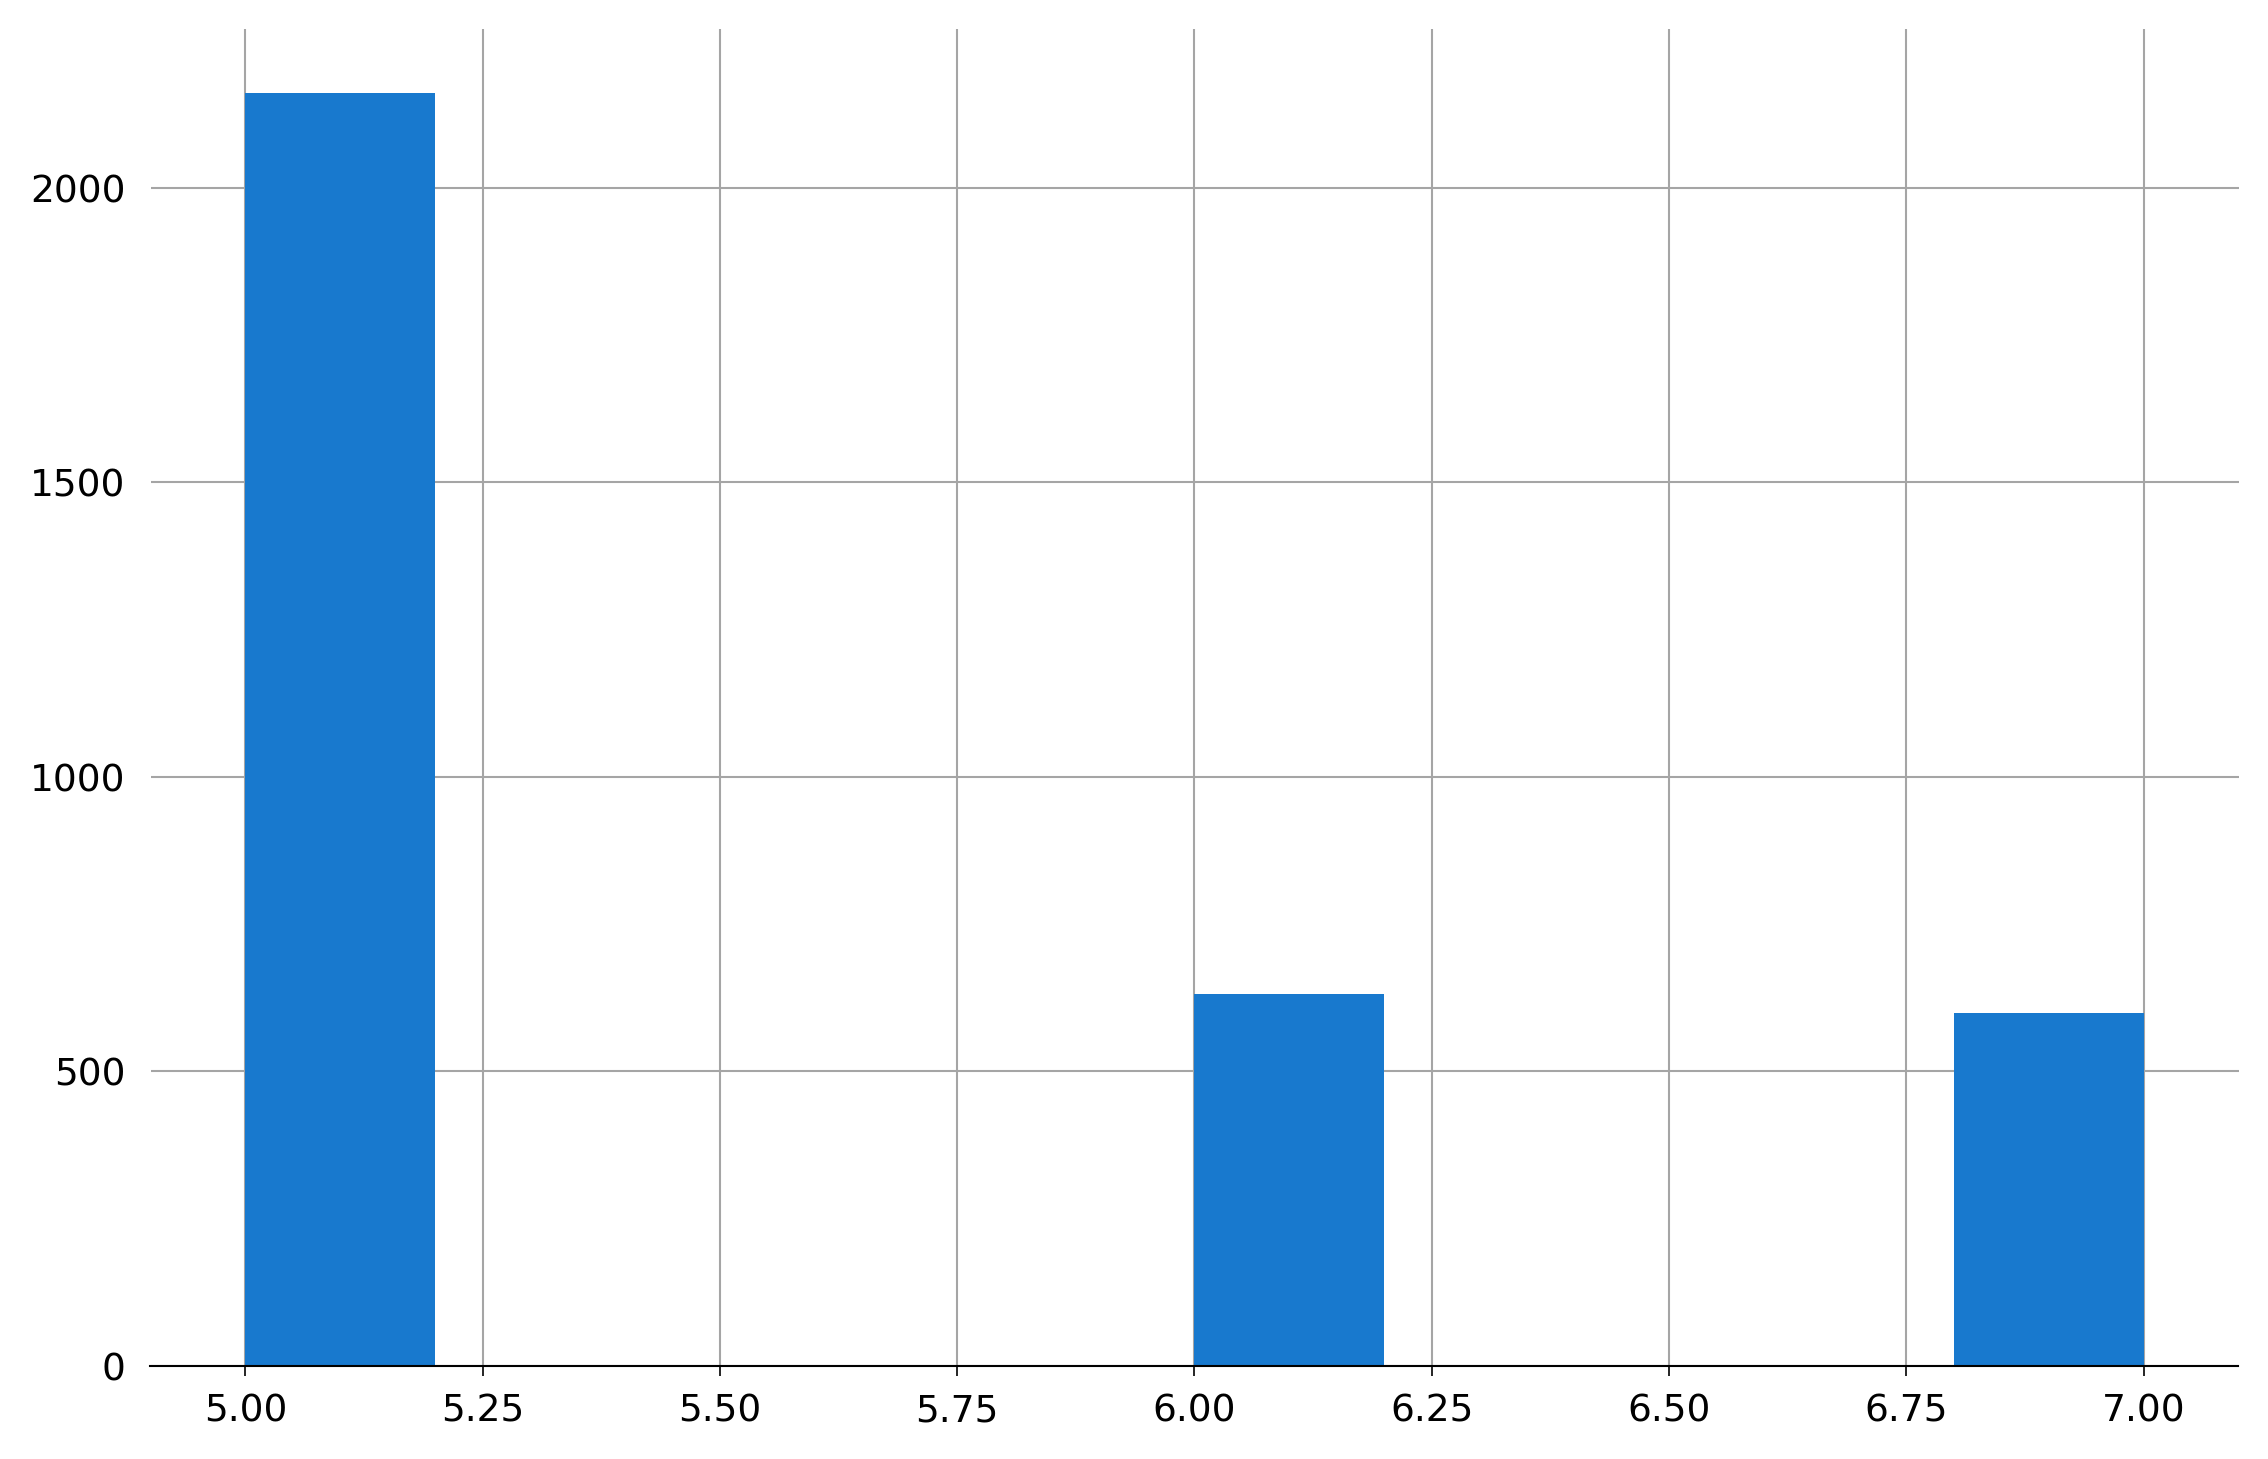

In [ ]:
flexible_listings['stay_days'].hist()

The flexible listings scraping was about between 5 and 7 days. But it seems only one listing had a long stay discount and none had a weekly discount. Could have been my scraper but I don't think so.

In [ ]:
flexible_listings[~flexible_listings['long_stay_discount'].isna()]

,weekly_discount,long_stay_discount,cleaning_fee,service_fee,price_minus_fees,title,guest,bedrooms,beds,baths,url,location,check_in,check_out,stay_days
1017,NaN,-$181,0,0,1205,Room in hotel hosted by Row NYC,2,1.0,1.0,1,https://www.airbnb.com/rooms/32678720?adults=1...,New-York-City--Manhattan--United-States,2023-05-01,2023-05-06,5


In [ ]:
flexible_listings[~flexible_listings['weekly_discount'].isna()]

,weekly_discount,long_stay_discount,cleaning_fee,service_fee,price_minus_fees,title,guest,bedrooms,beds,baths,url,location,check_in,check_out,stay_days


Finally let's clean up the city name. 

In [ ]:
flexible_listings['city'] = flexible_listings['location'].str.split("--").str.get(0)
flexible_listings['city'] = flexible_listings['city'].str.replace("-", " ")

### Clean one_day_listings

Ok now let's do the same thing for the one day listings.

In [ ]:
one_day_listings

,weekly_discount,long_stay_discount,cleaning_fee,service_fee,price_minus_fees,title,guest,bedrooms,beds,baths,url,location,check_in,check_out
0,NaN,NaN,$30,$12,$58,Entire rental unit hosted by Leonard,3,1.0,1.0,1,https://www.airbnb.com/rooms/16353509?check_in...,Dallas--TX--United-States,2022-11-02,2022-11-03
1,NaN,NaN,$40,$14,$58,Entire loft hosted by Simaiya,4,1.0,1.0,1,https://www.airbnb.com/rooms/67089461123550275...,Dallas--TX--United-States,2022-11-02,2022-11-03
2,NaN,NaN,$35,$15,$69,Entire rental unit hosted by Frontdesk,4,1.0,1.0,1,https://www.airbnb.com/rooms/50029383?check_in...,Dallas--TX--United-States,2022-11-02,2022-11-03
3,NaN,NaN,$30,$13,$65,Entire loft hosted by Leonard,6,1.0,2.0,1,https://www.airbnb.com/rooms/39844580?check_in...,Dallas--TX--United-States,2022-11-02,2022-11-03
4,NaN,NaN,NaN,$14,$100,Entire rental unit hosted by Dante,3,1.0,1.0,1,https://www.airbnb.com/rooms/69933821236595629...,Dallas--TX--United-States,2022-11-02,2022-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3561,NaN,NaN,$80,$0,$177,Entire rental unit hosted by Jean-Charles,4,1.0,2.0,1,https://www.airbnb.com/rooms/50883915?check_in...,Paris,2022-11-02,2022-11-03
3562,NaN,NaN,NaN,NaN,$108,Room in boutique hotel hosted by Hotel De L’Aq...,1,1.0,1.0,1,https://www.airbnb.com/rooms/35145340?check_in...,Paris,2022-11-02,2022-11-03
3563,NaN,NaN,$64,$0,$173,Entire rental unit hosted by Jérémy,3,NaN,2.0,1,https://www.airbnb.com/rooms/47417486?check_in...,Paris,2022-11-02,2022-11-03
3564,NaN,NaN,$72,$0,$143,Entire rental unit hosted by Karim,2,1.0,1.0,1,https://www.airbnb.com/rooms/68604321515452884...,Paris,2022-11-02,2022-11-03


In [ ]:
one_day_listings['check_in'] = pd.to_datetime(one_day_listings['check_in'])
one_day_listings['check_out'] = pd.to_datetime(one_day_listings['check_out'])

In [ ]:
one_day_listings['cleaning_fee'] = one_day_listings['cleaning_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
one_day_listings['service_fee'] = one_day_listings['service_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
one_day_listings['price_minus_fees'] = one_day_listings['price_minus_fees'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")

/tmp/ipykernel_3847/322107567.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  one_day_listings['cleaning_fee'] = one_day_listings['cleaning_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
/tmp/ipykernel_3847/322107567.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  one_day_listings['service_fee'] = one_day_listings['service_fee'].str.replace("$","").str.replace(",","").fillna(value=0).astype("int")
/tmp/ipykernel_3847/322107567.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  one_day_l

In [ ]:
one_day_listings['stay_days'] = (one_day_listings['check_out'] - one_day_listings['check_in']).dt.days

Well it looks like the scraper worked properly on the days.

In [ ]:
one_day_listings['stay_days'].mean()

1.0

In [ ]:
one_day_listings['city'] = one_day_listings['location'].str.split("--").str.get(0)
one_day_listings['city'] = one_day_listings['city'].str.replace("-", " ")

## What is the average Airbnb cleaning fee?

First let's look at the difference in cleaning fees for listings.

In [ ]:
flexible_listings['cleaning_fee'].mean()

50.206723680330285

In [ ]:
one_day_listings['cleaning_fee'].mean()

35.62450925406618

Almost 28% of one day listings have no cleaning fees.

In [ ]:
one_day_listings[one_day_listings['cleaning_fee'] == 0].shape[0] / one_day_listings.shape[0]

0.2781828379136287

Only 13% of multi day listings have no cleaning fees.

In [ ]:
flexible_listings[flexible_listings['cleaning_fee'] == 0].shape[0] / flexible_listings.shape[0]

0.1338838100855205

The service fee is for Airbnb. They seem to charge right at 15%.

In [ ]:
(flexible_listings['service_fee'] / flexible_listings['price_minus_fees']).mean()

0.14593970653802638

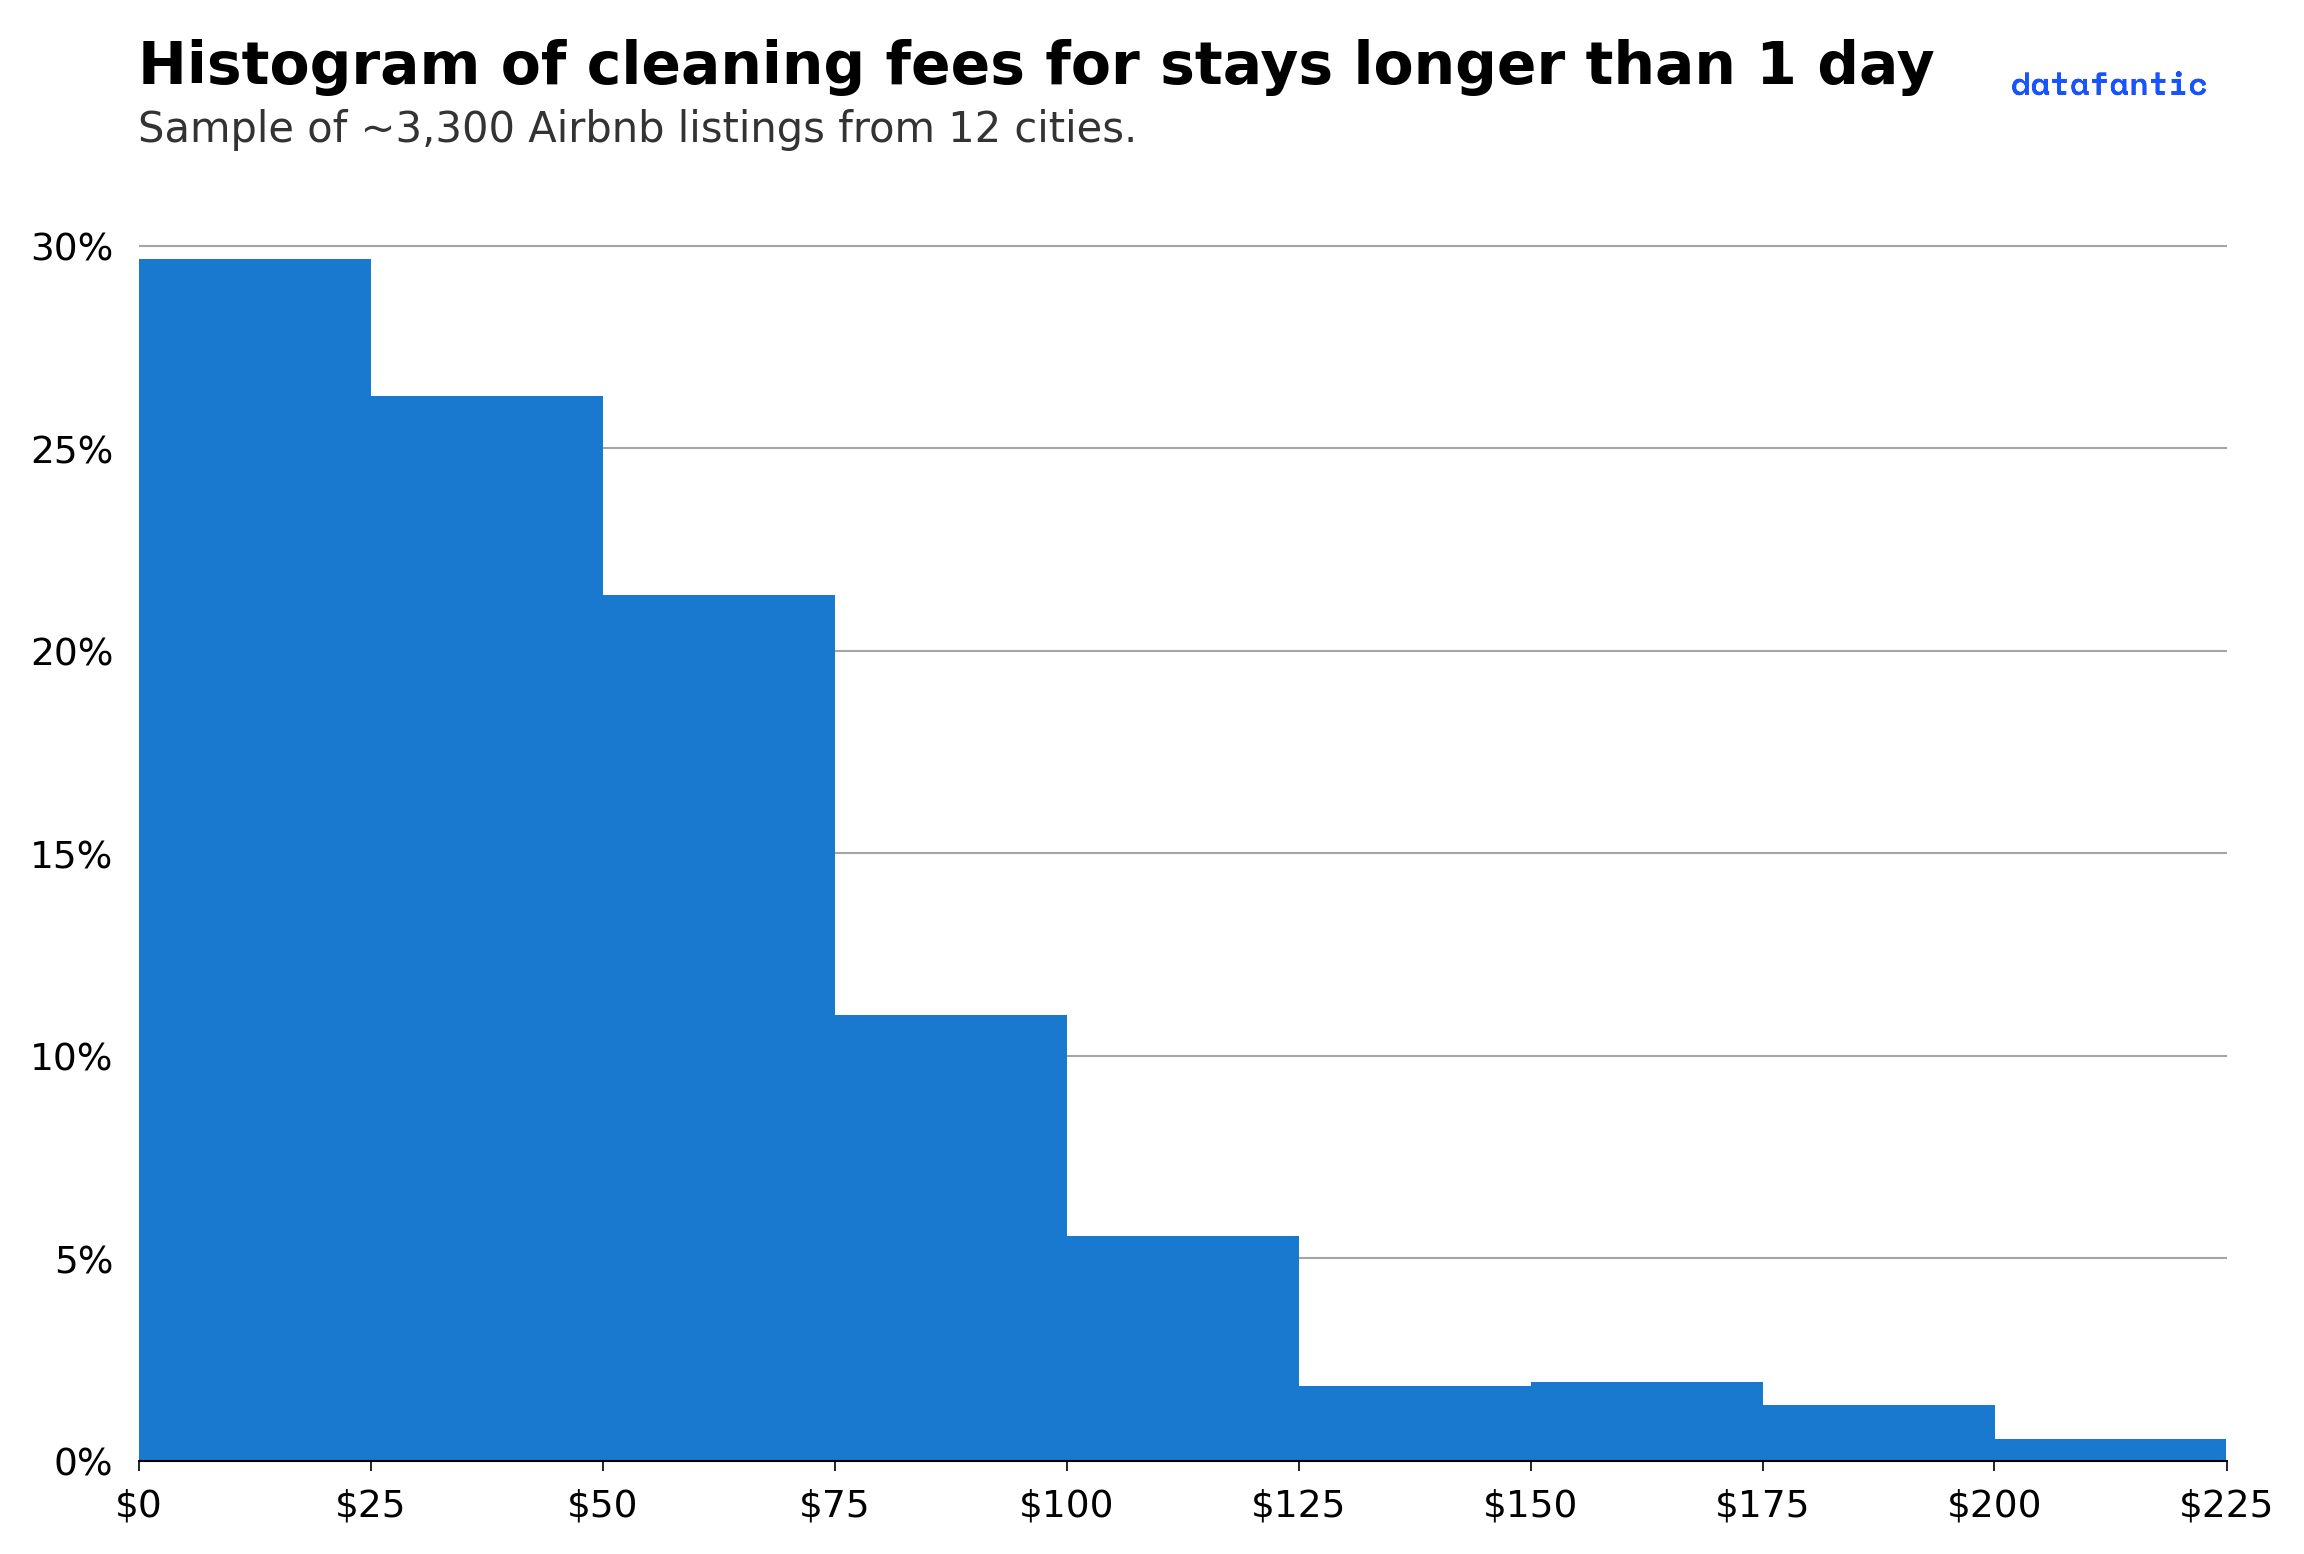

In [ ]:
fig, ax = plt.subplots()
ax.hist(flexible_listings['cleaning_fee'], 
        bins=range(0, 400, 25), 
        weights=np.ones(len(flexible_listings['cleaning_fee'])) / len(flexible_listings['cleaning_fee']))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .33)

# Add in title and subtitle
ax.set_title("""Histogram of cleaning fees for stays longer than 1 day""")
ax.text(x=.08, y=.87, 
        s="Sample of ~3,300 Airbnb listings from 12 cities.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.22)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/multi_day_histogram.png')

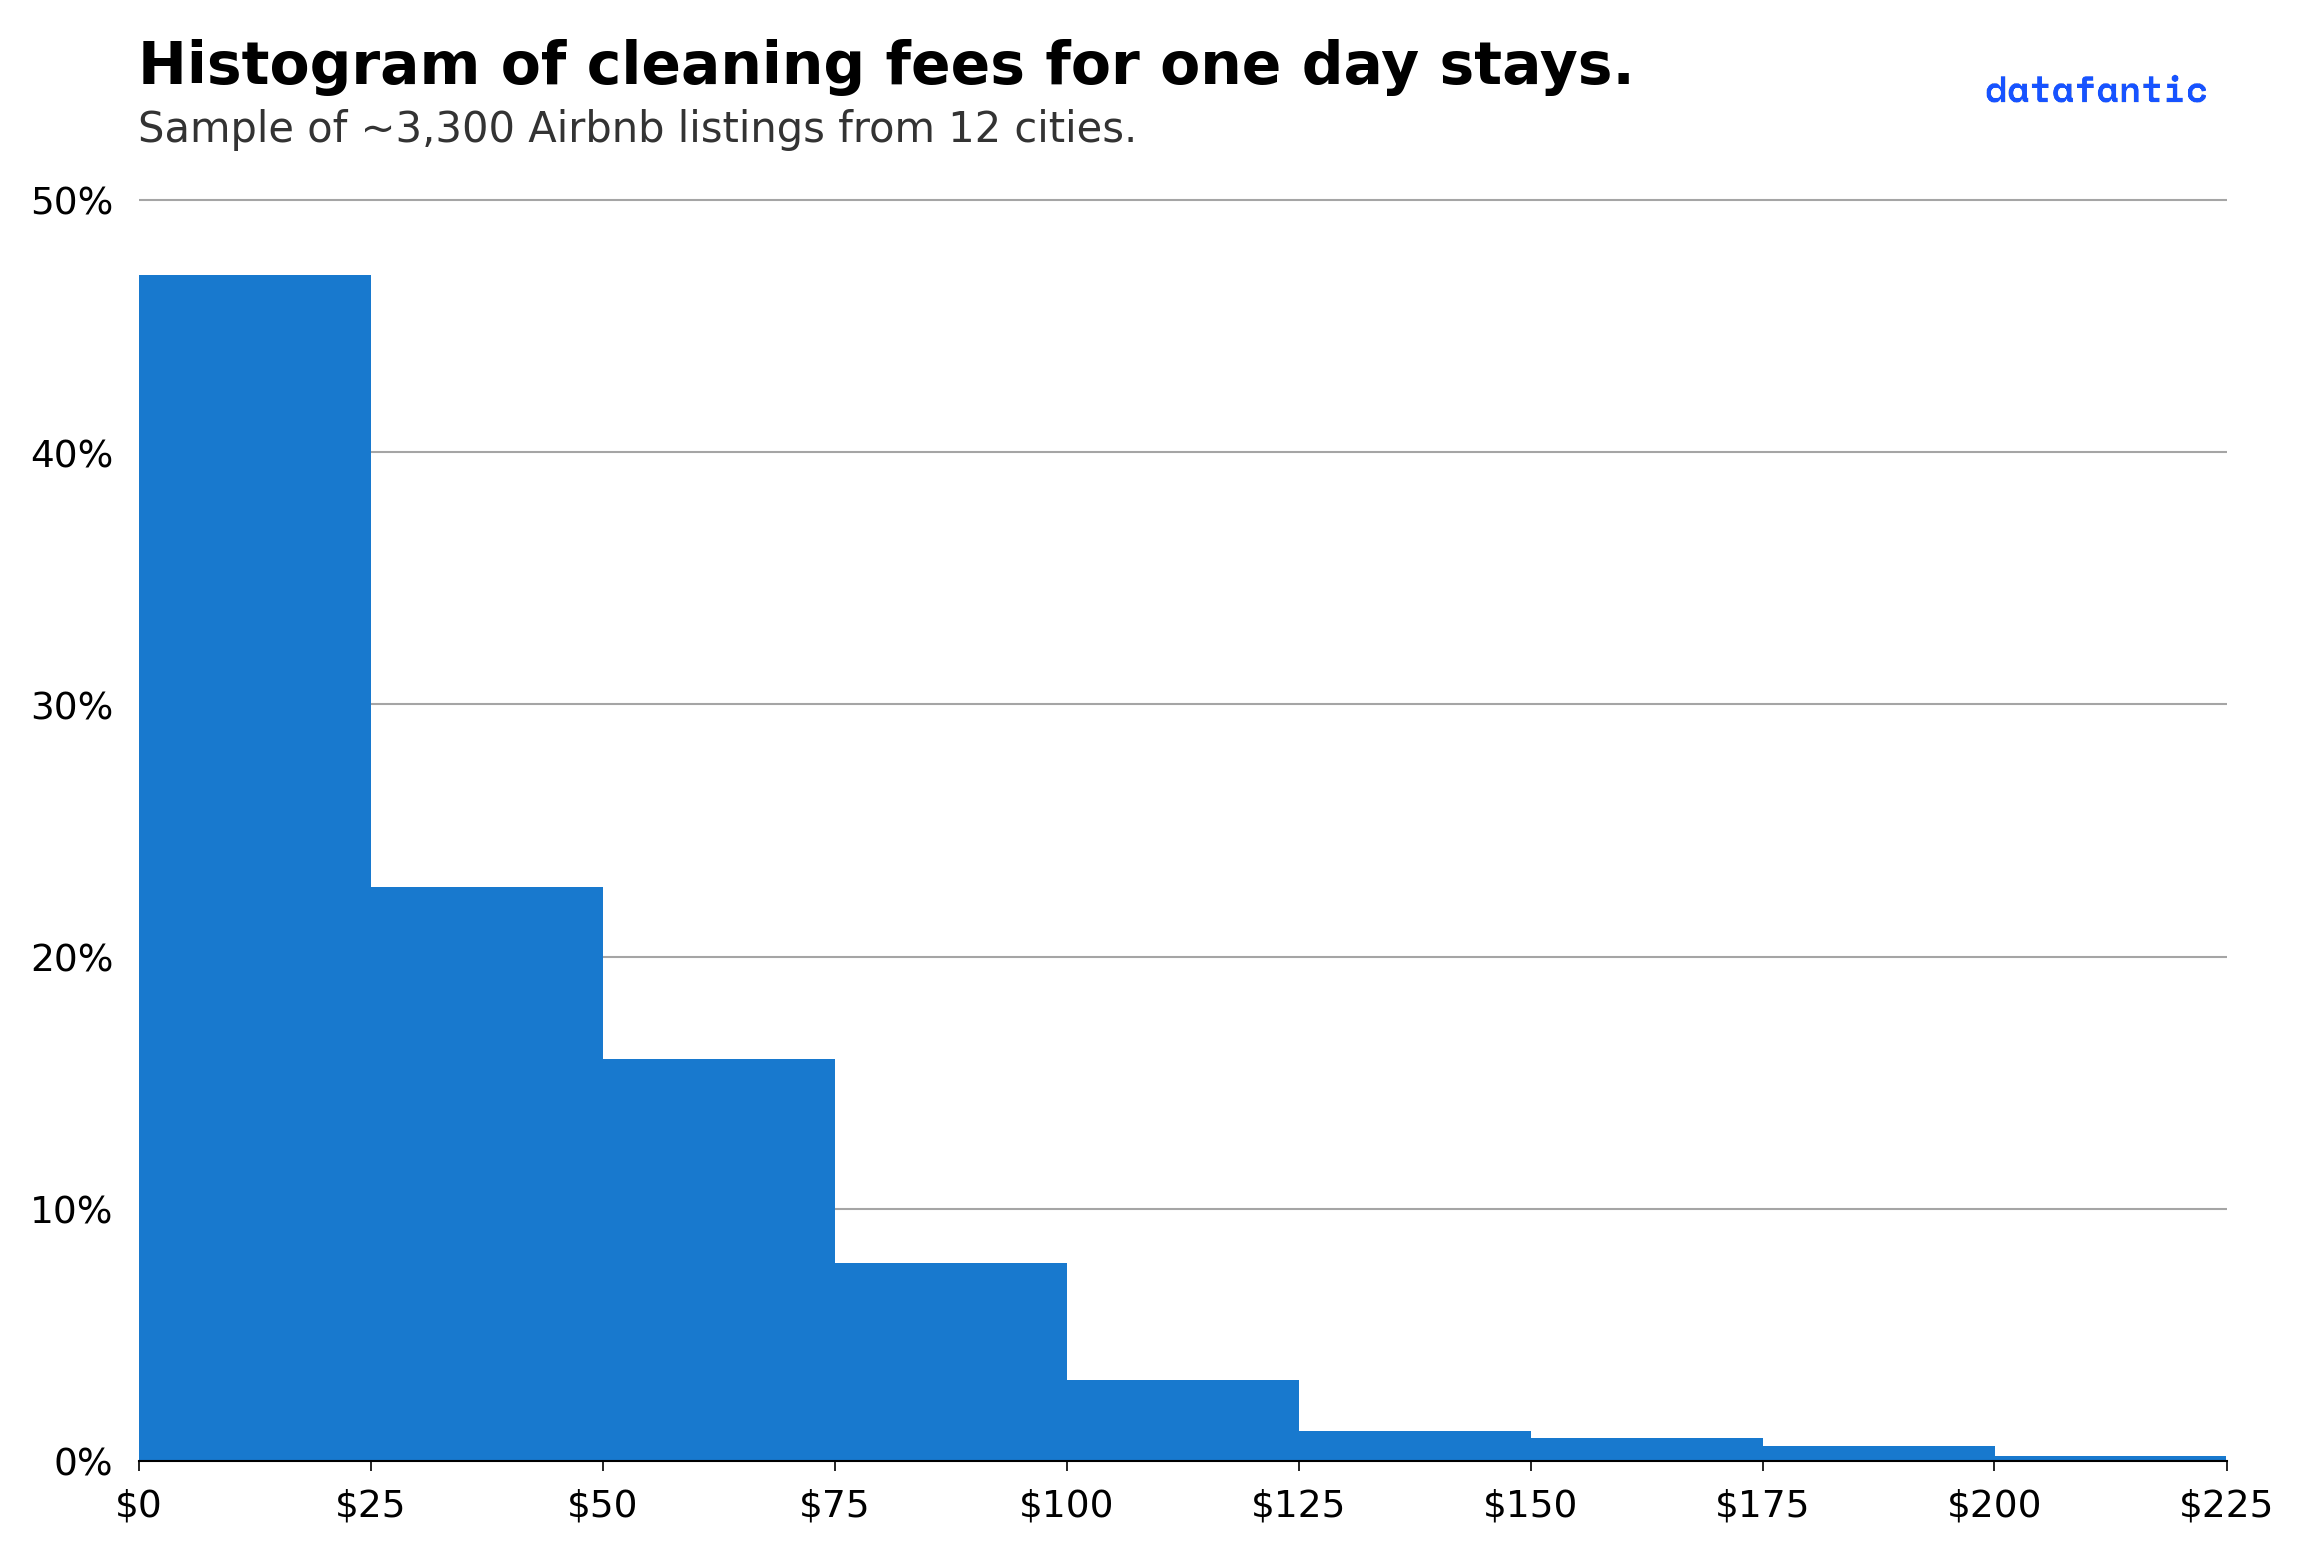

In [ ]:
fig, ax = plt.subplots()
ax.hist(one_day_listings['cleaning_fee'], 
        bins=range(0, 400, 25), 
        weights=np.ones(len(one_day_listings['cleaning_fee'])) / len(one_day_listings['cleaning_fee']))

ax.set_xlim(0, 225)
ax.set_ylim(0, 1750)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .53)

# Add in title and subtitle
ax.set_title("""Histogram of cleaning fees for one day stays.""")
ax.text(x=.08, y=.87, 
        s="Sample of ~3,300 Airbnb listings from 12 cities.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/one_day_histogram.png')

In [ ]:
one_day_listings[one_day_listings['cleaning_fee'] > 50].shape[0] / one_day_listings.shape[0] * 100

26.275939427930457

## Do certain cities have higher cleaning fees than others? Are there country differences?

In [ ]:
fees_city = flexible_listings.groupby(by="city").mean()['cleaning_fee'].reset_index()

In [ ]:
fees_city = fees_city.sort_values('cleaning_fee', ascending=False)

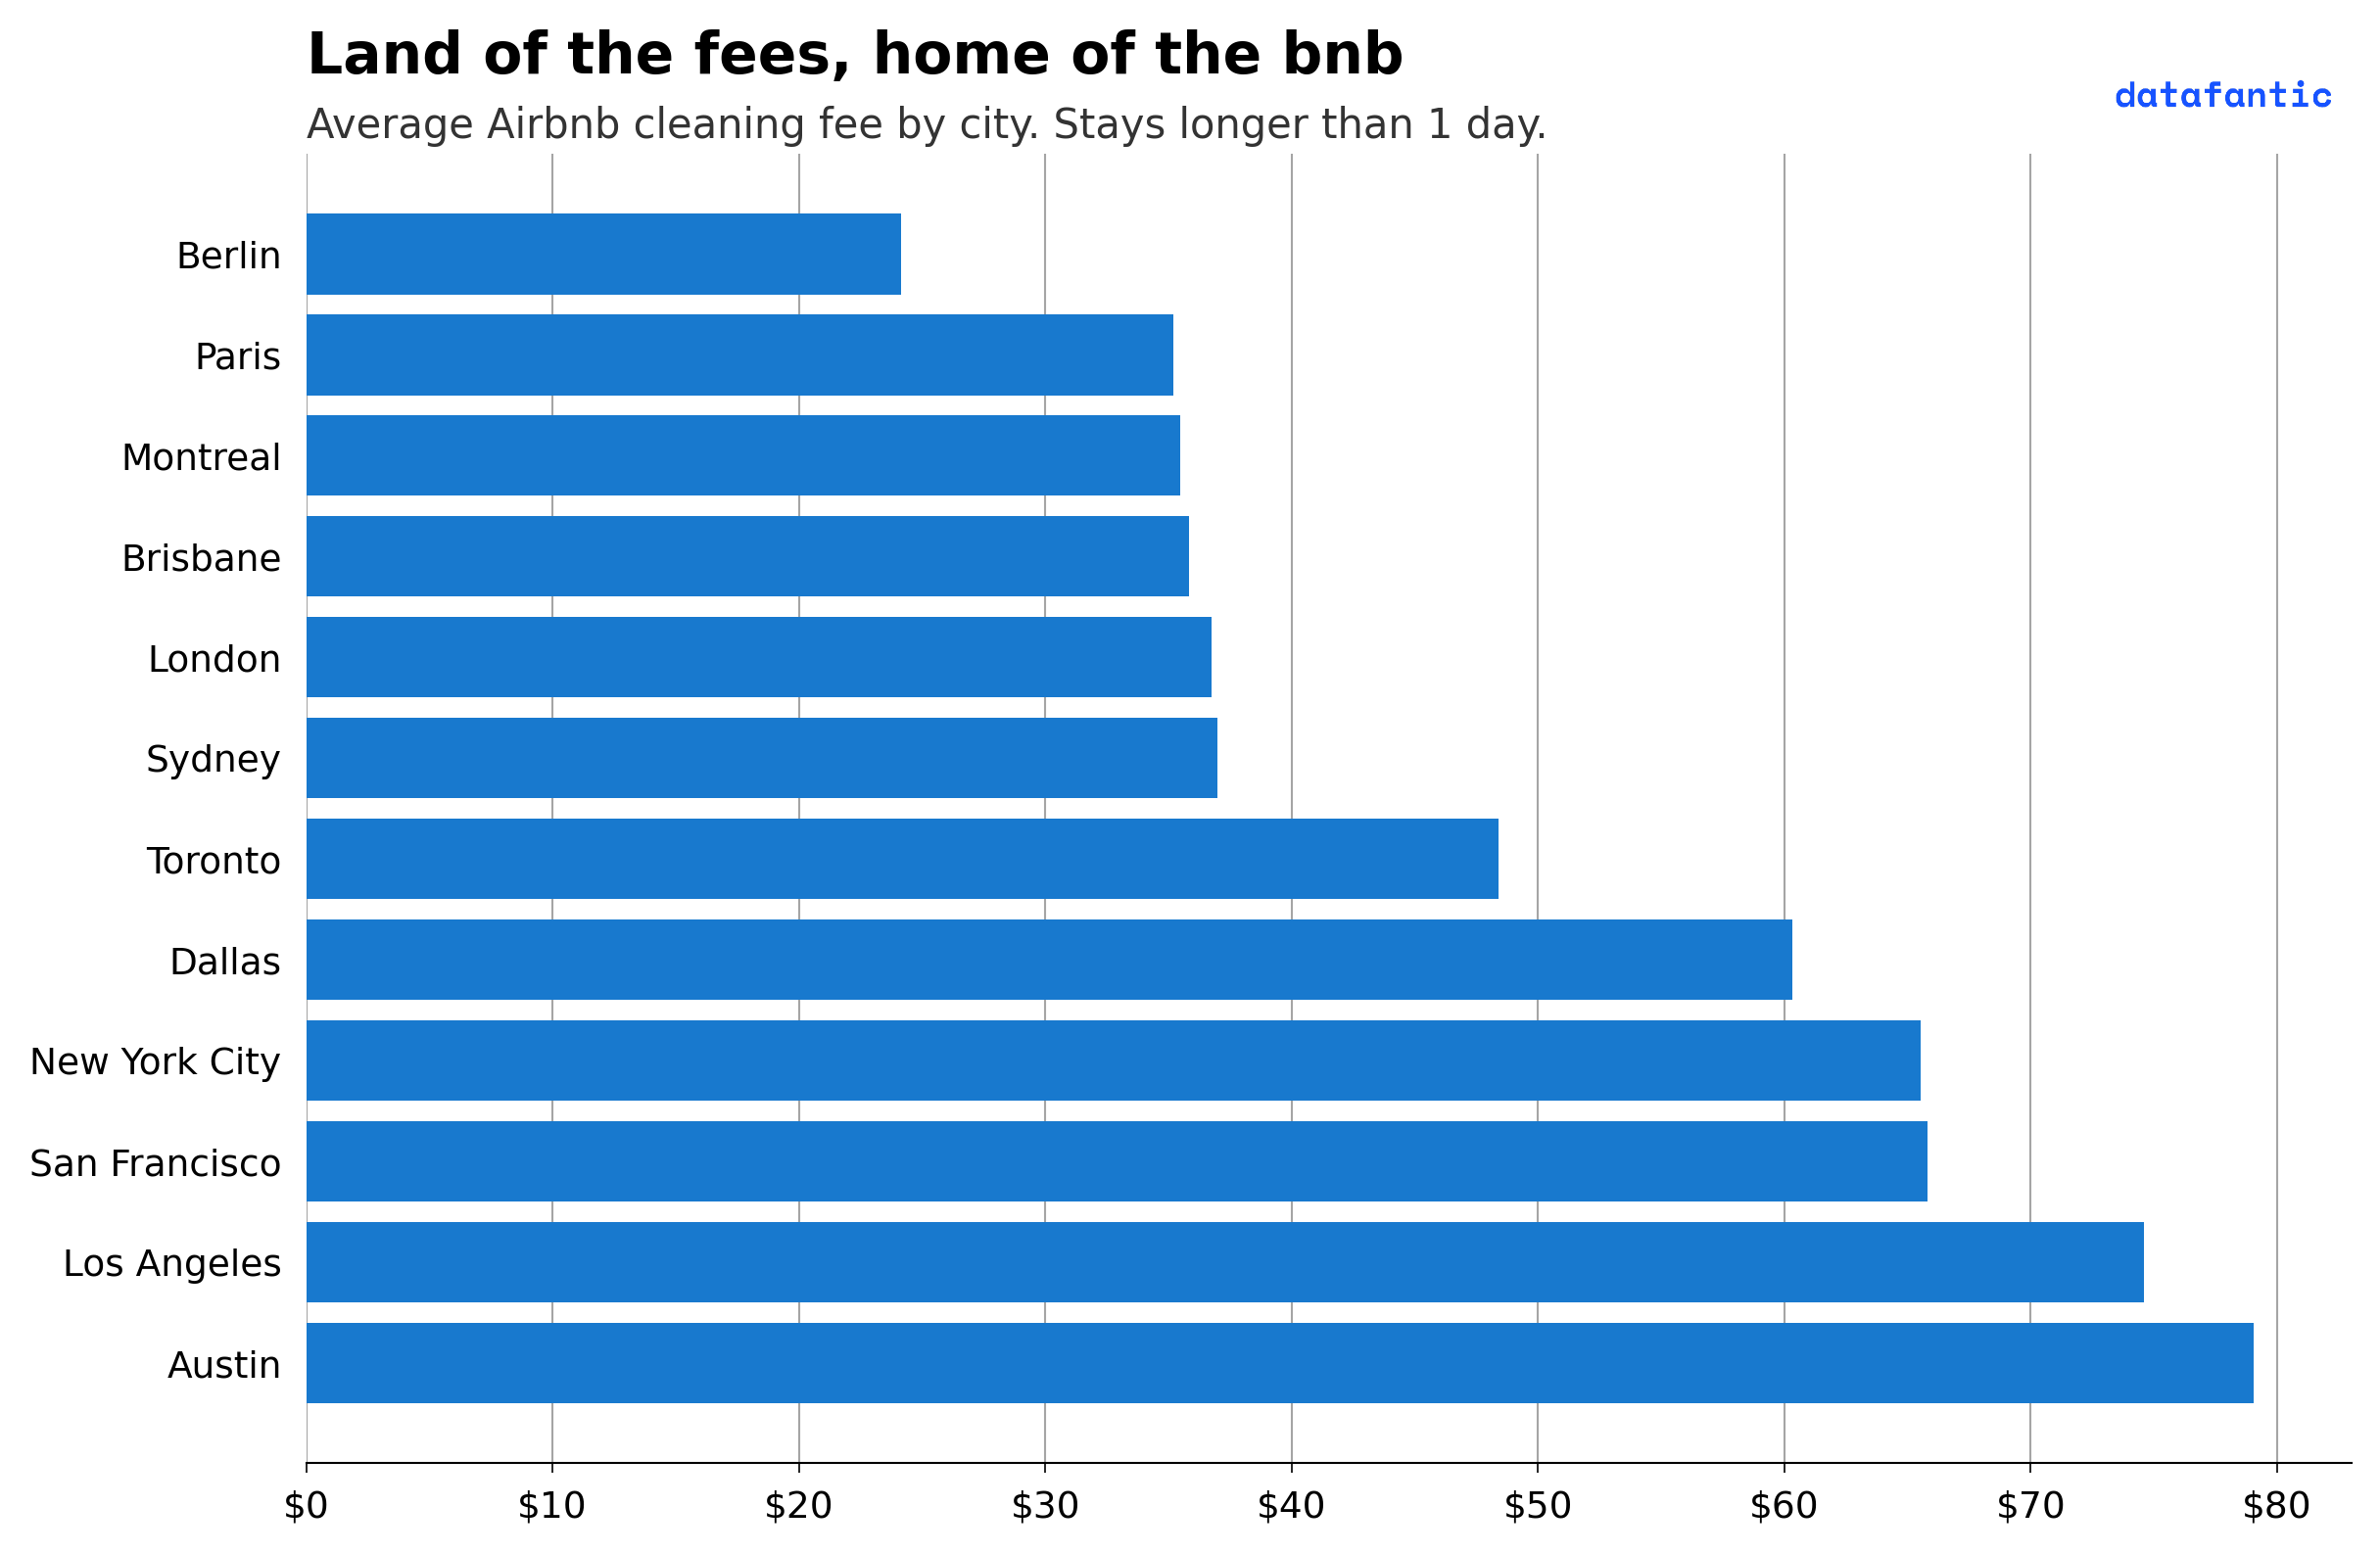

In [ ]:
fig, ax = plt.subplots()
ax.barh(fees_city['city'], fees_city['cleaning_fee'])
ax.grid(visible=False, axis='y')
ax.grid(visible=True, axis='x')

ax.xaxis.set_major_formatter('${x:1.0f}')

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Land of the fees, home of the bnb""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')
ax.text(x=.08, y=.89, 
        s="Average Airbnb cleaning fee by city. Stays longer than 1 day.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.08), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/fees_by_city.png')

In [ ]:
all_listings = pd.concat([flexible_listings,one_day_listings])

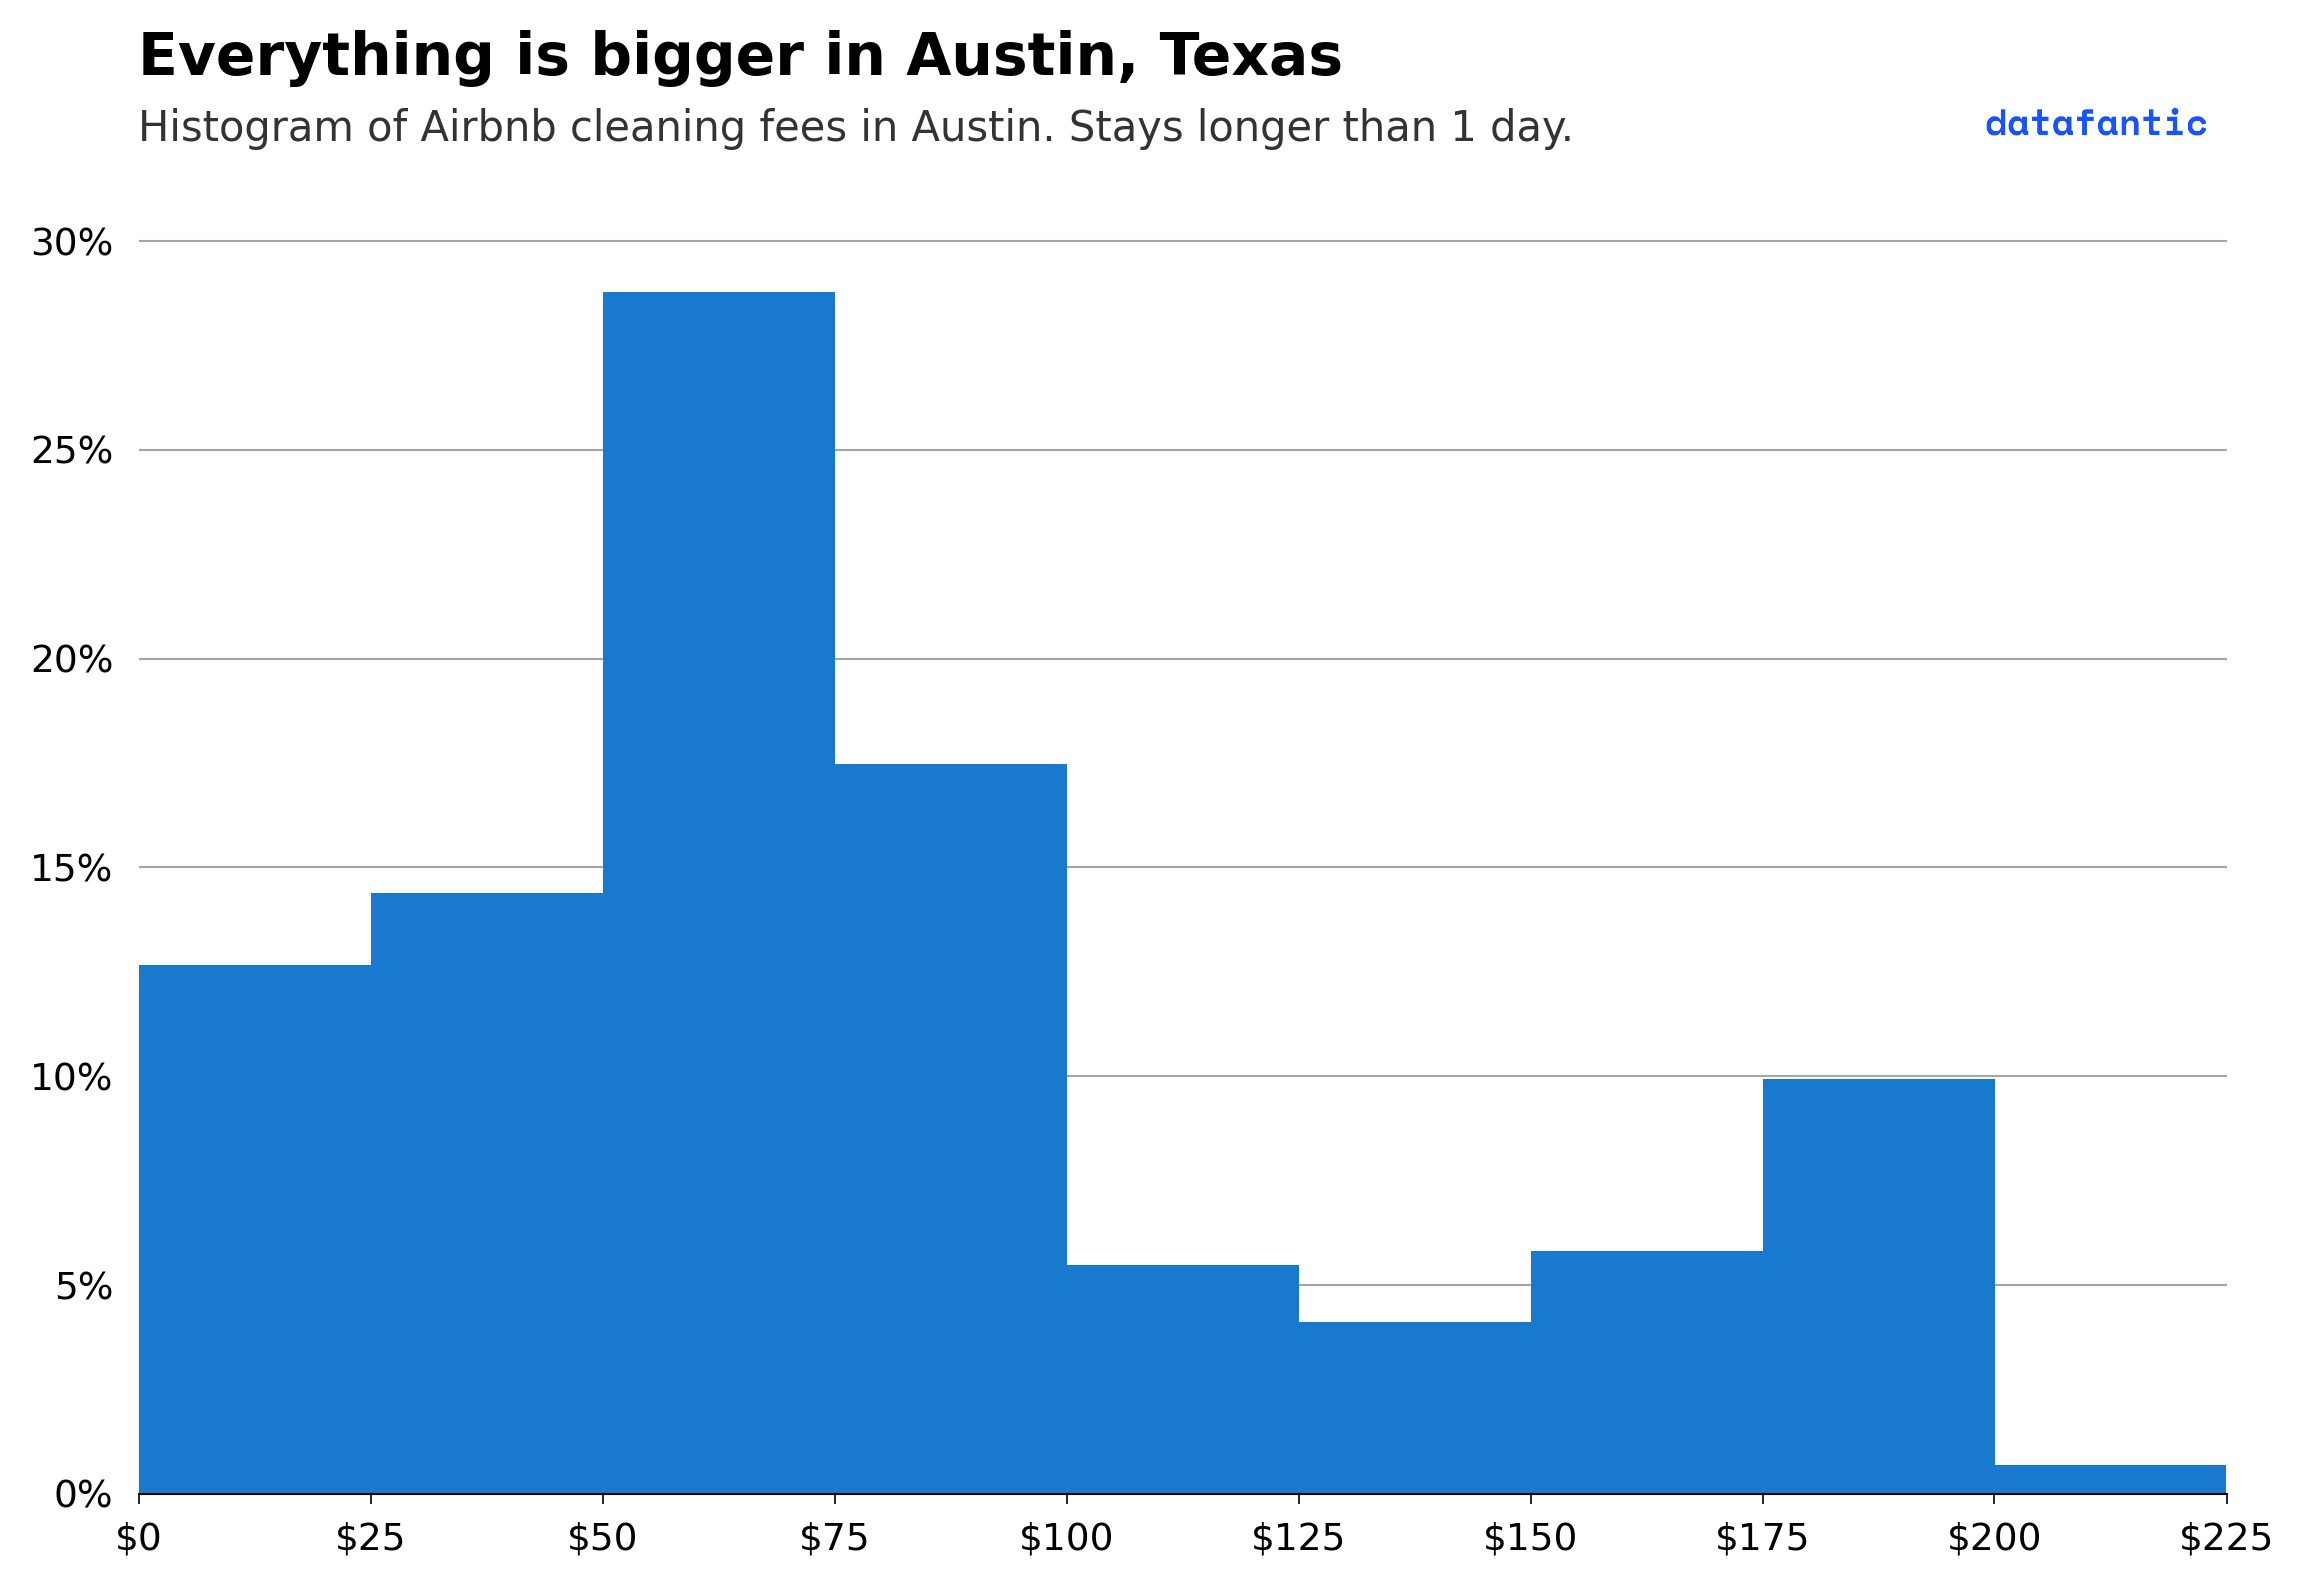

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'Austin']['cleaning_fee']
fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25), 
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .32)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Everything is bigger in Austin, Texas""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')
ax.text(x=.08, y=.89, 
        s="Histogram of Airbnb cleaning fees in Austin. Stays longer than 1 day.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/austin_histogram.png')

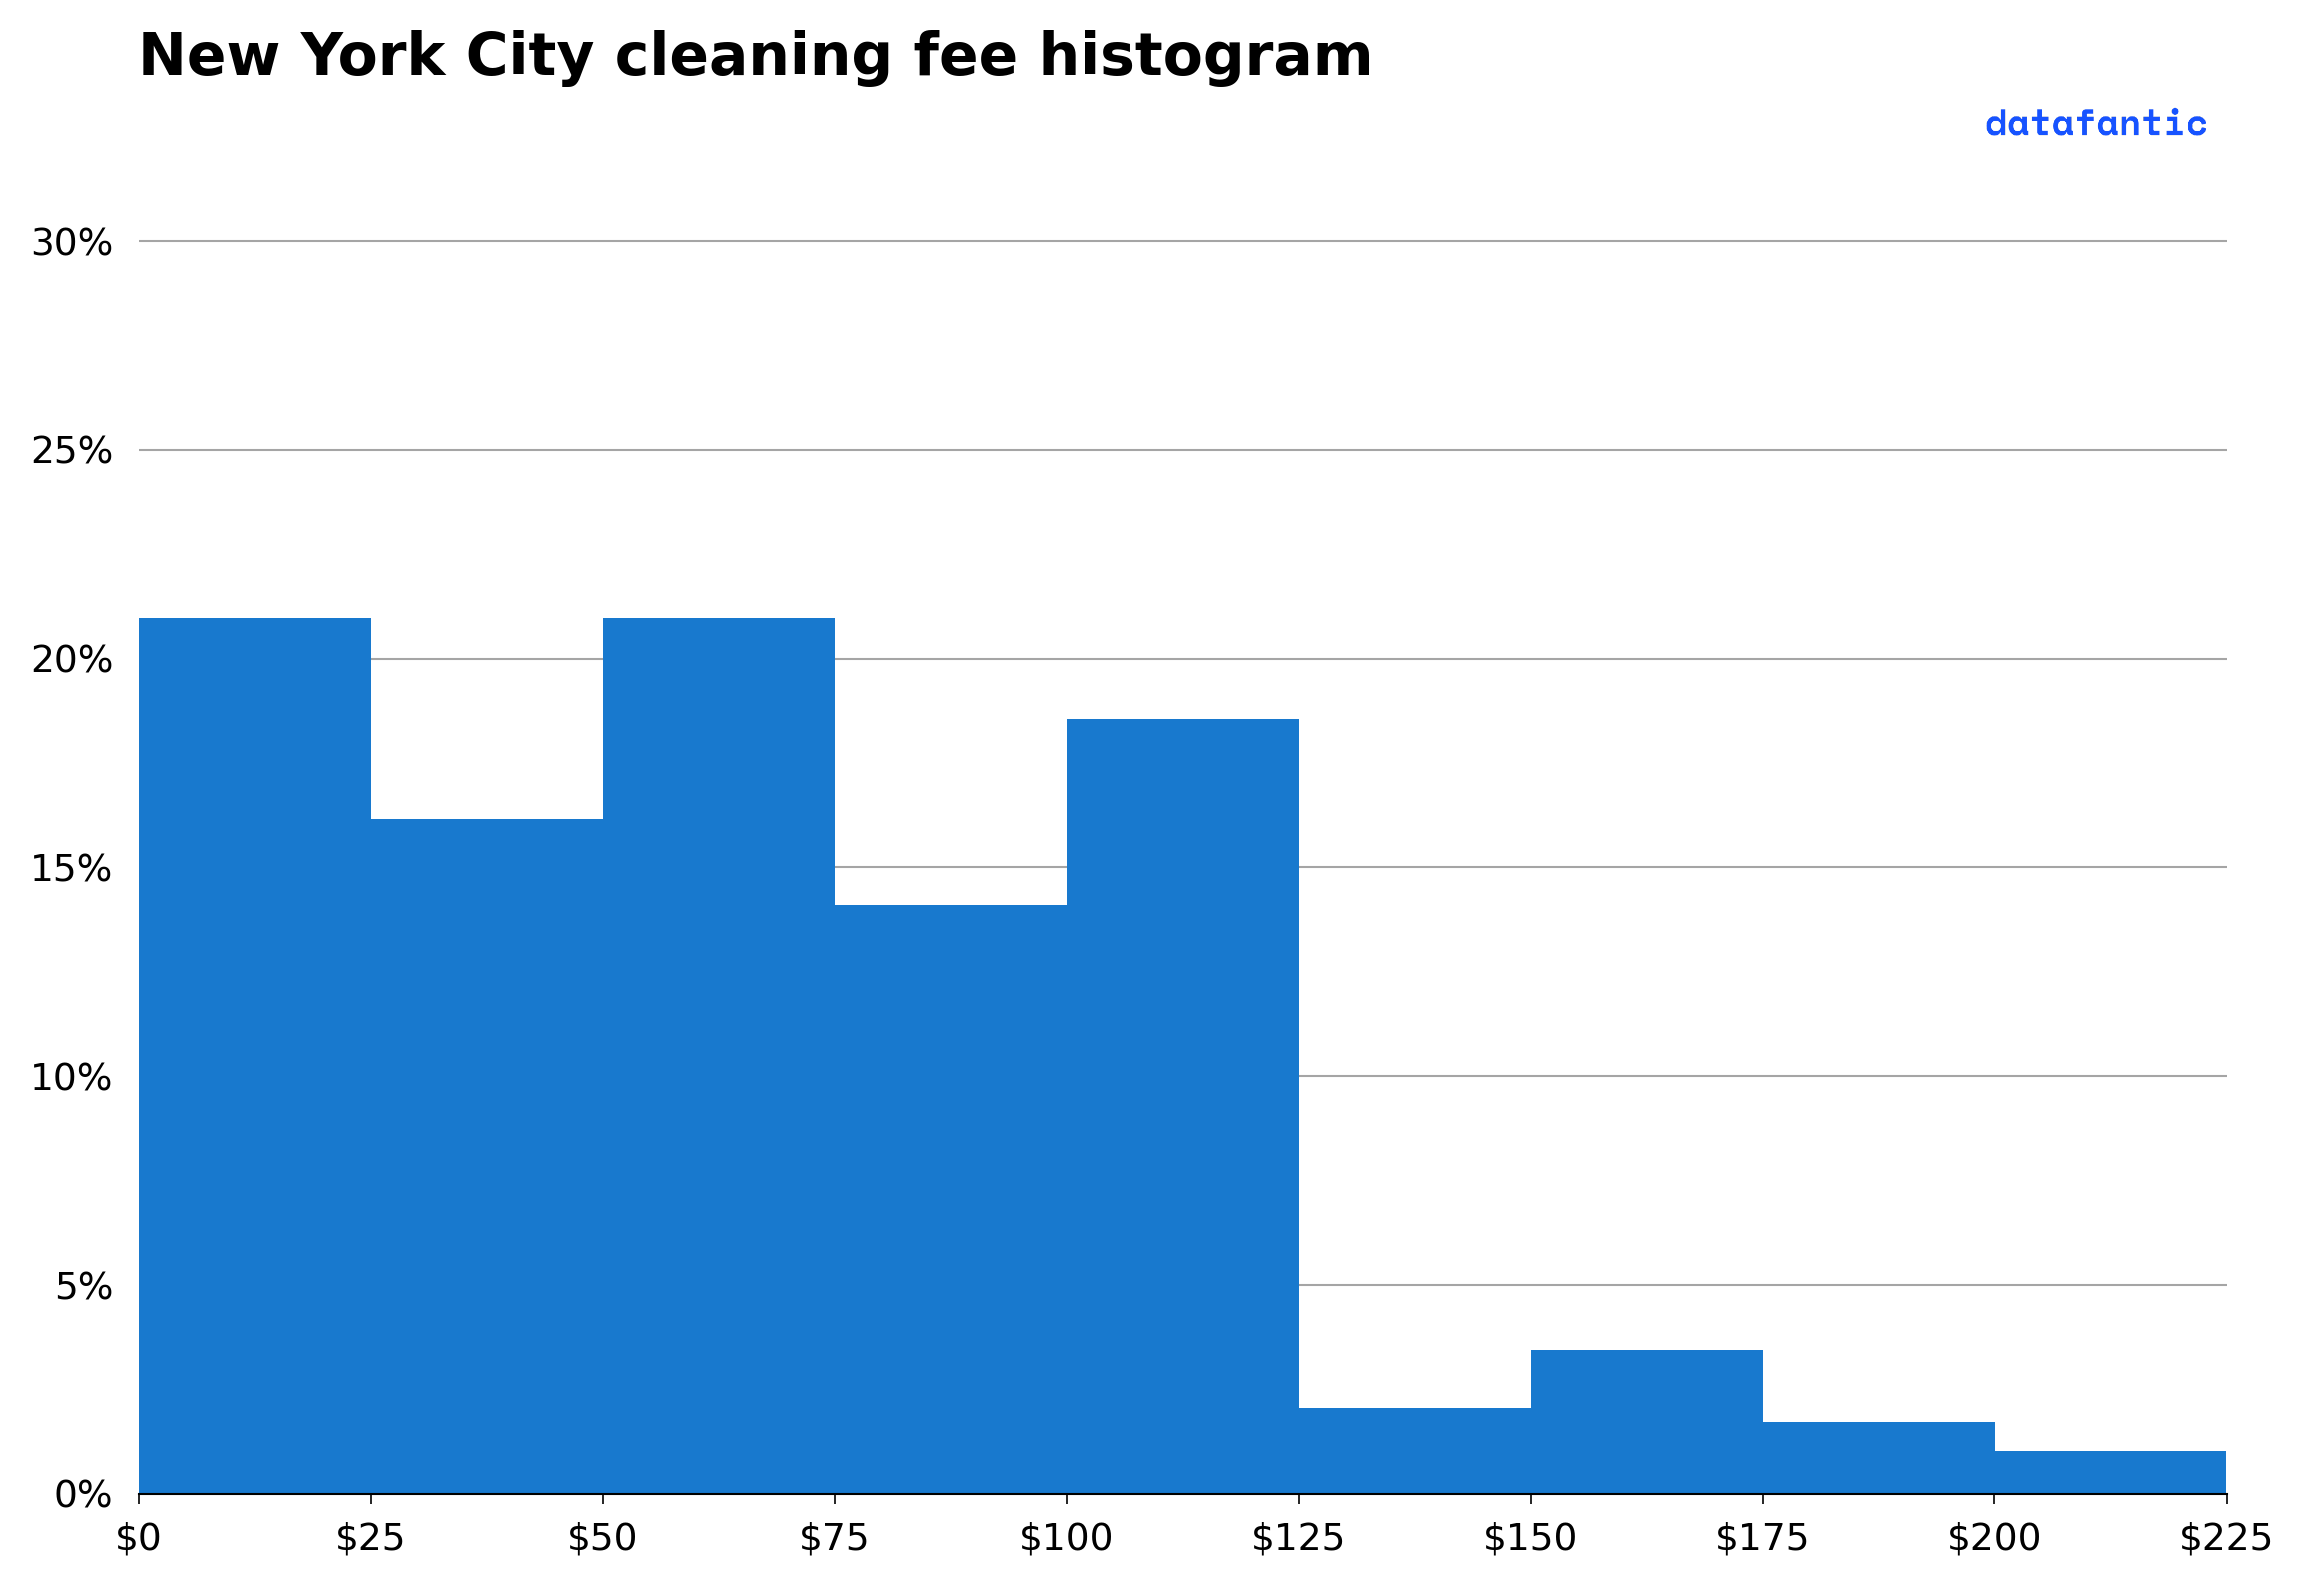

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'New York City']['cleaning_fee']
fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25), 
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .32)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""New York City cleaning fee histogram""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

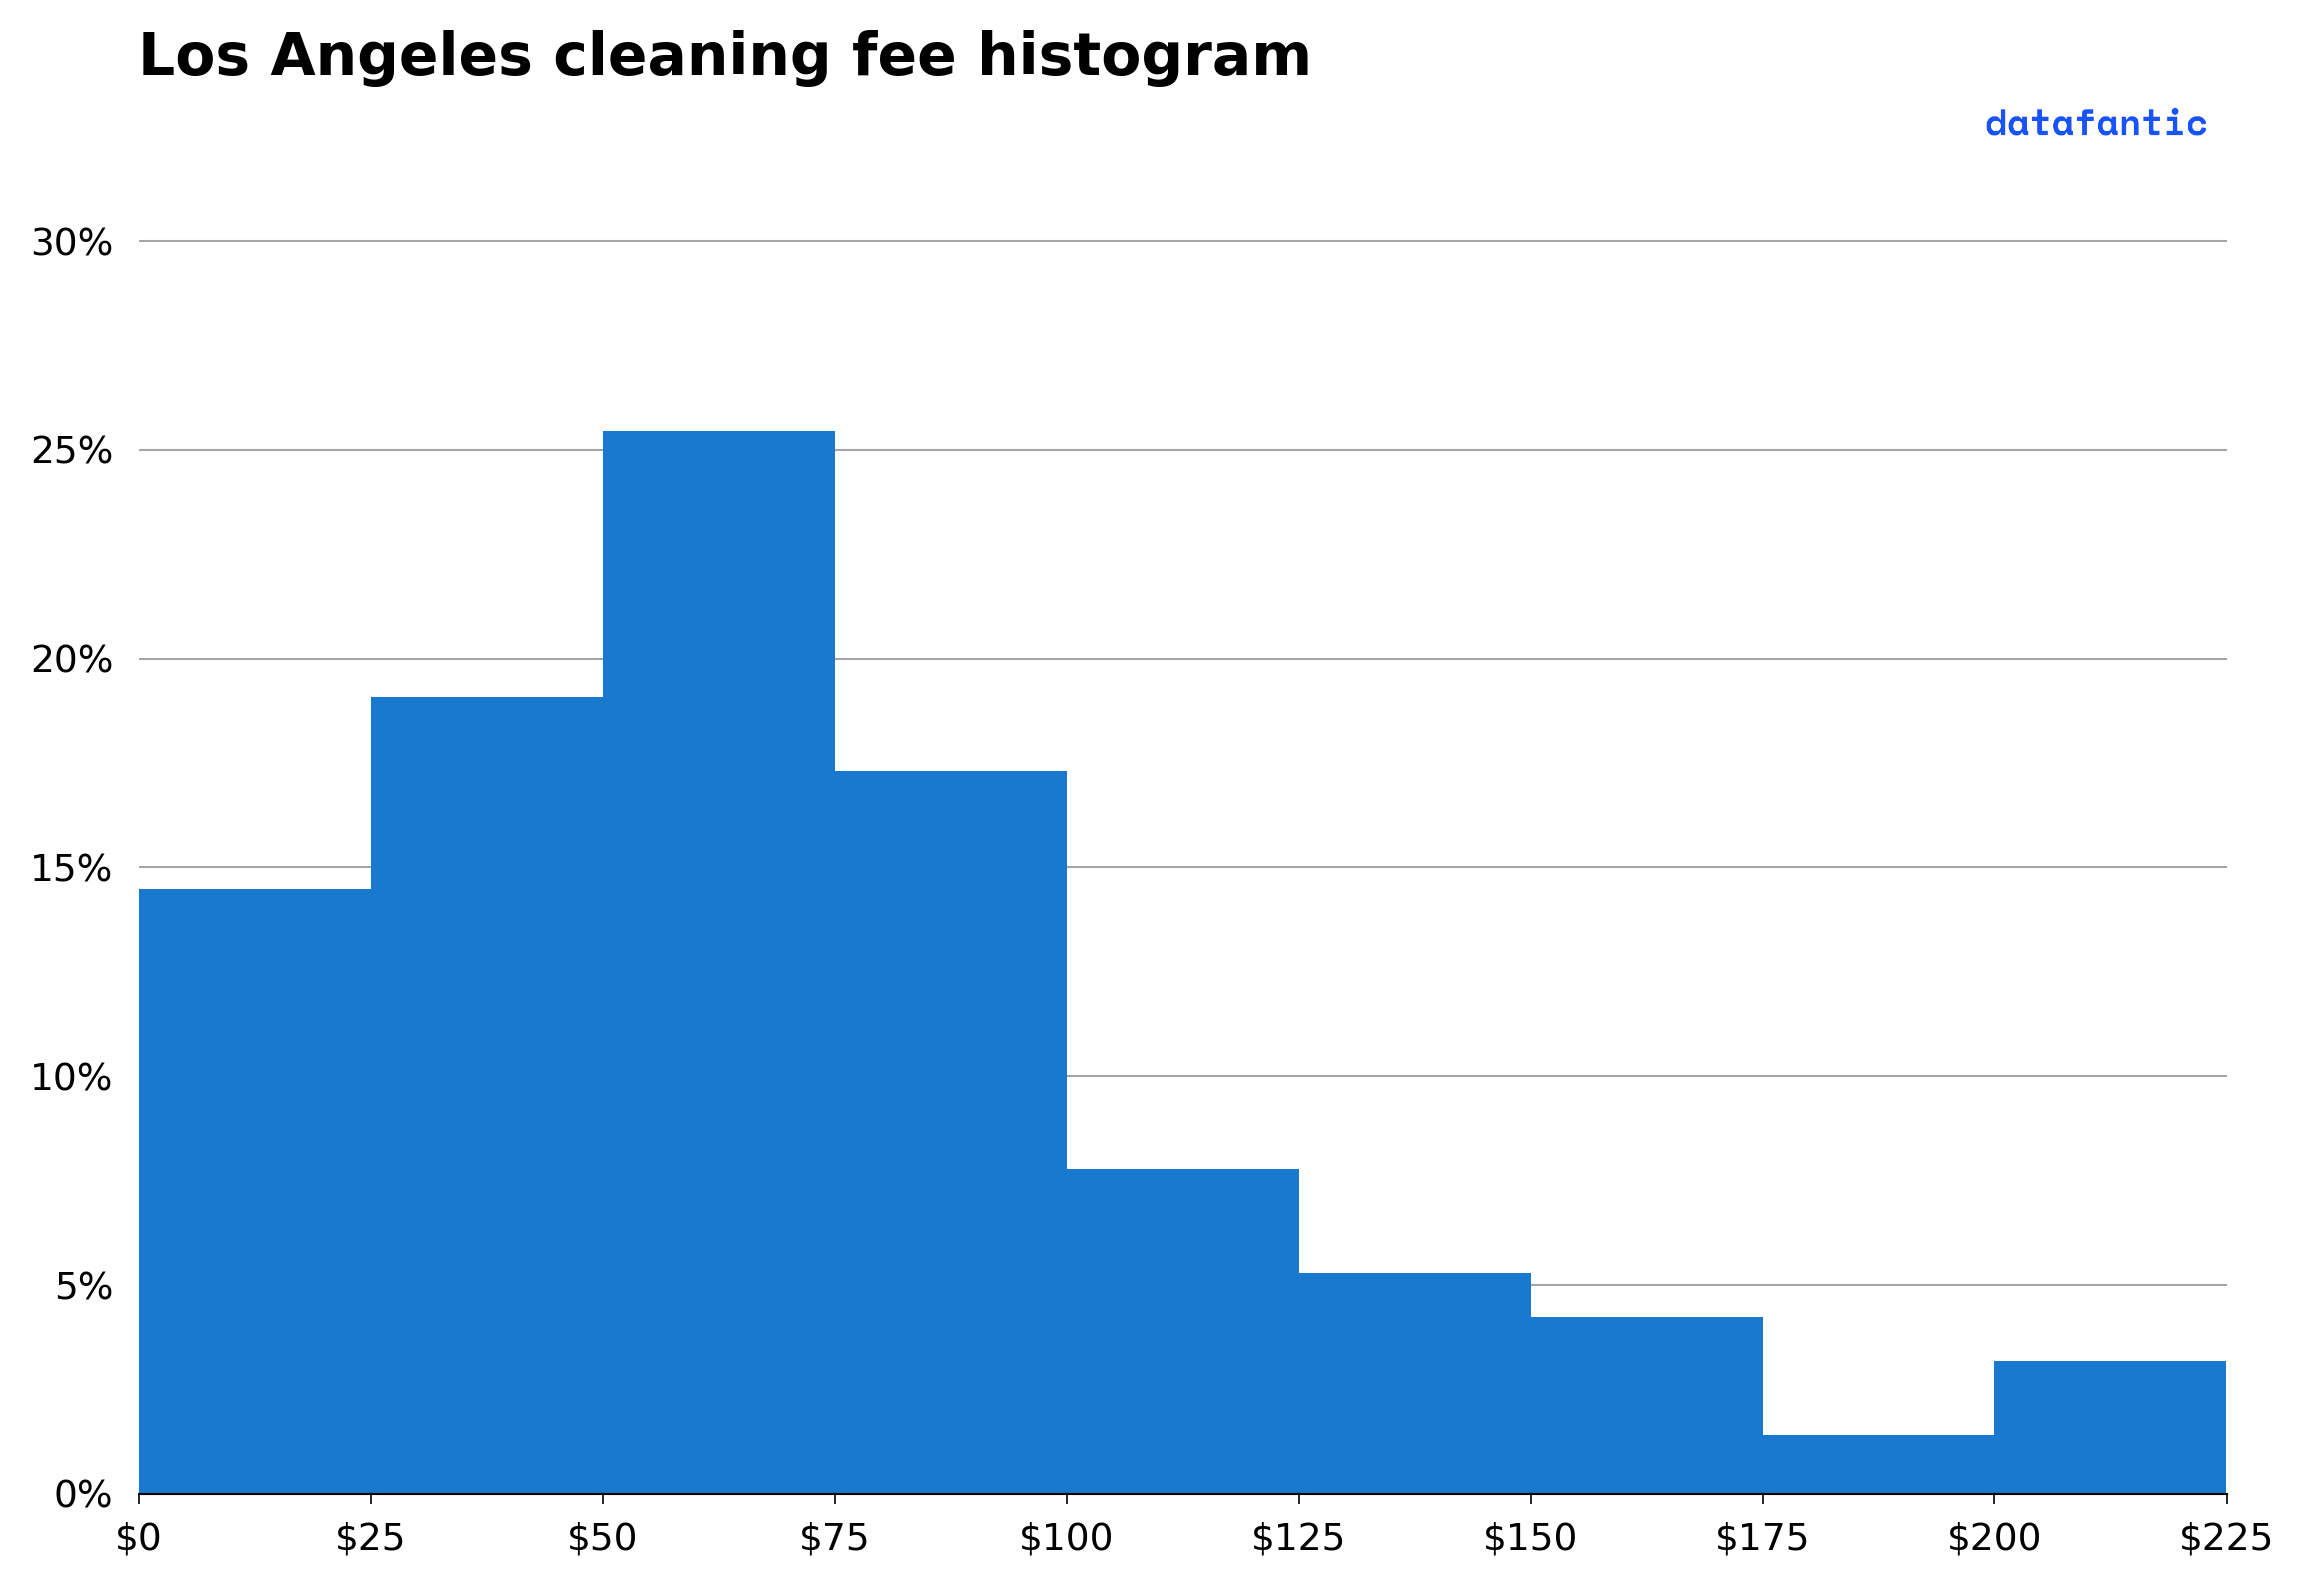

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'Los Angeles']['cleaning_fee']
fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25), 
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .32)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Los Angeles cleaning fee histogram""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

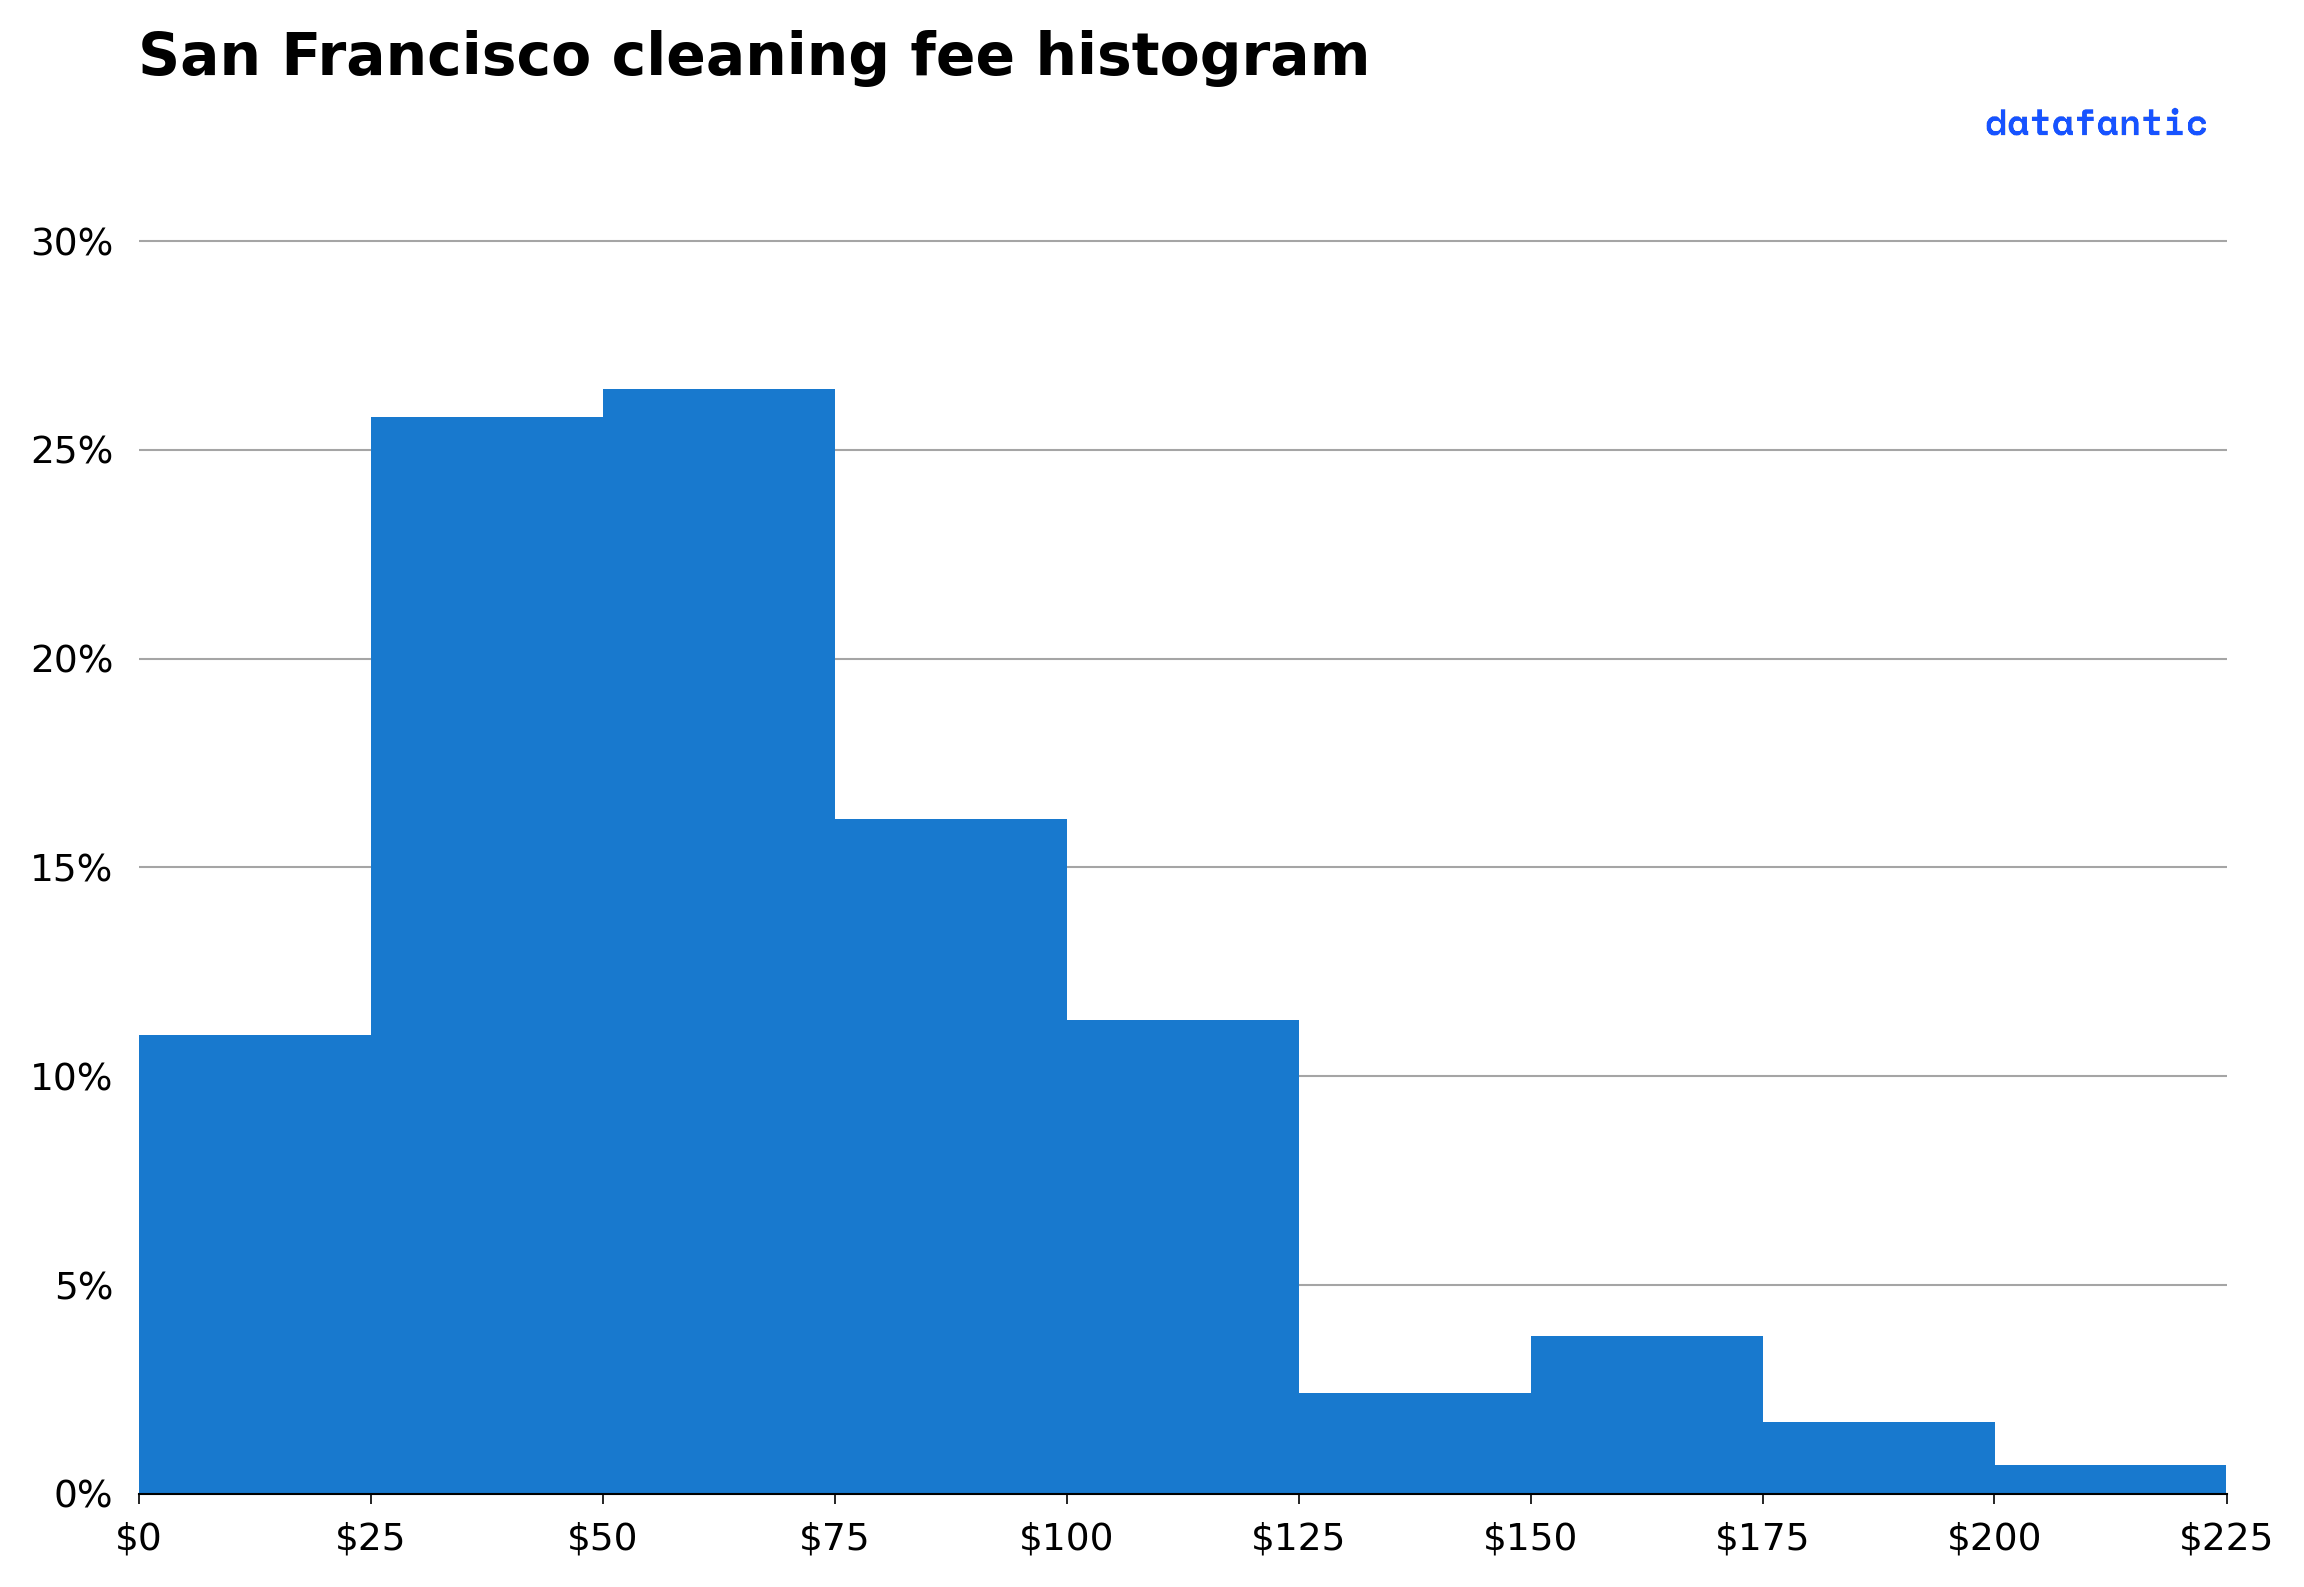

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'San Francisco']['cleaning_fee']
fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25), 
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .32)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""San Francisco cleaning fee histogram""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

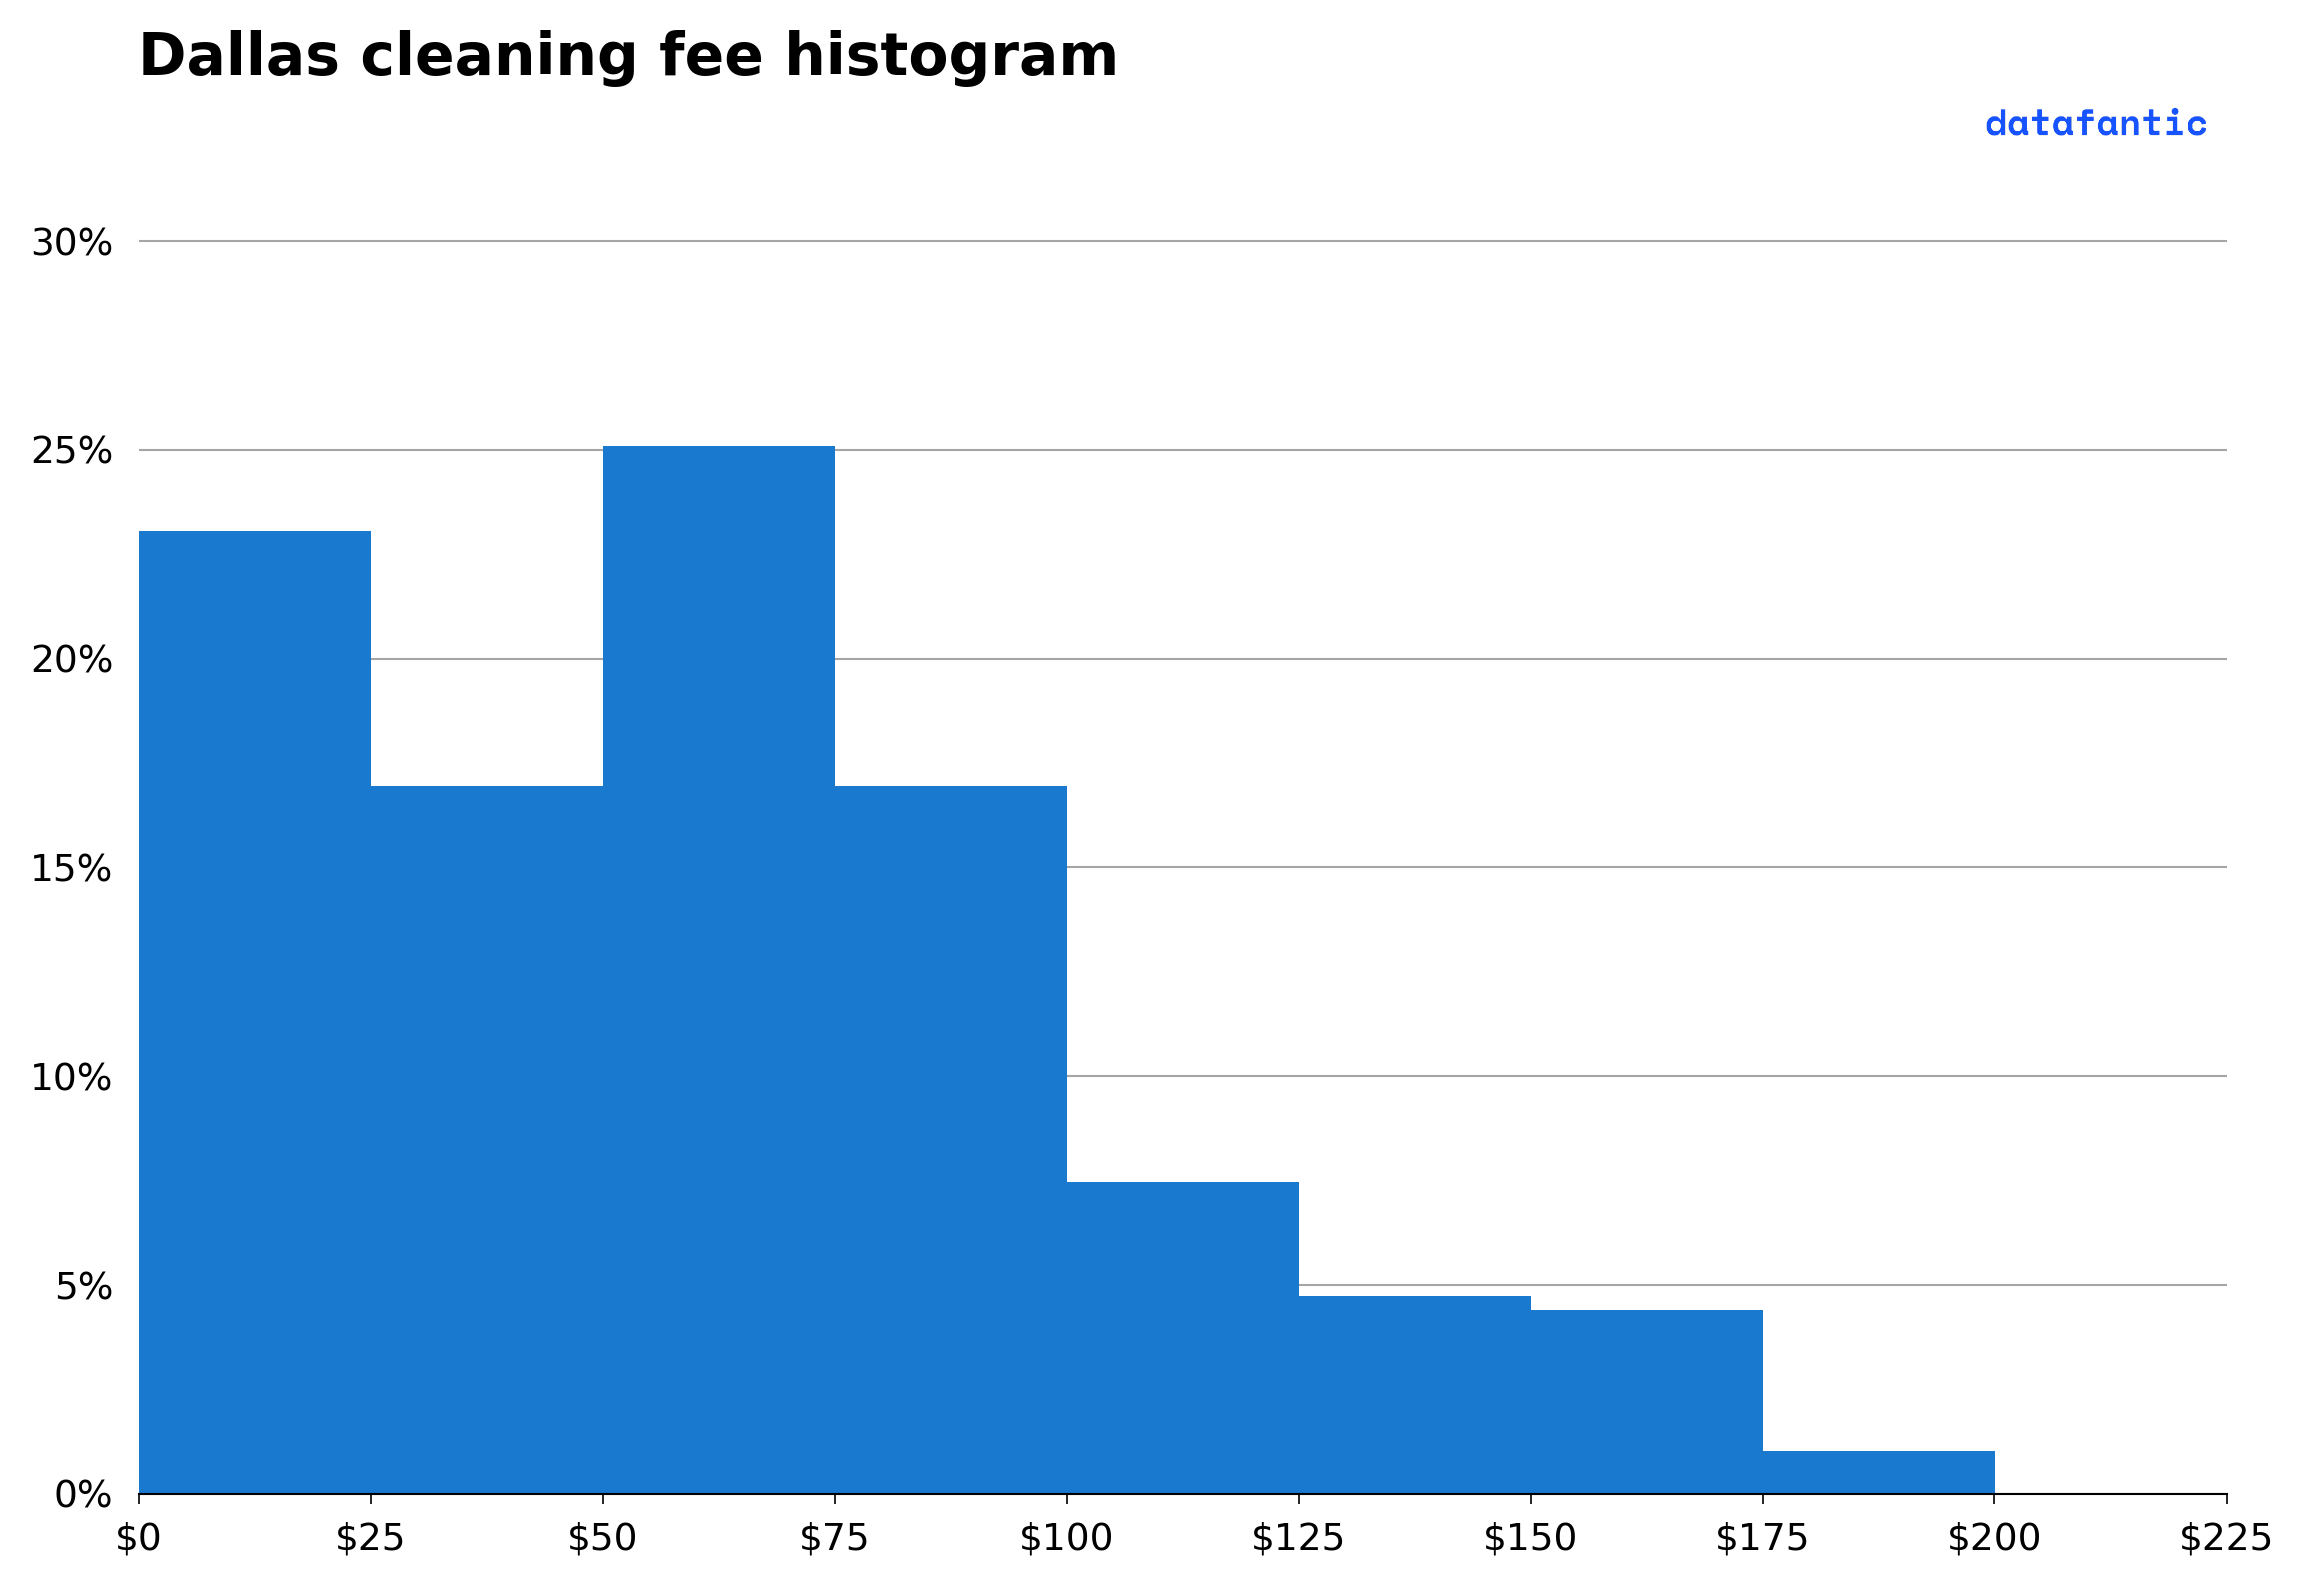

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'Dallas']['cleaning_fee']
fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25), 
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .32)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Dallas cleaning fee histogram""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

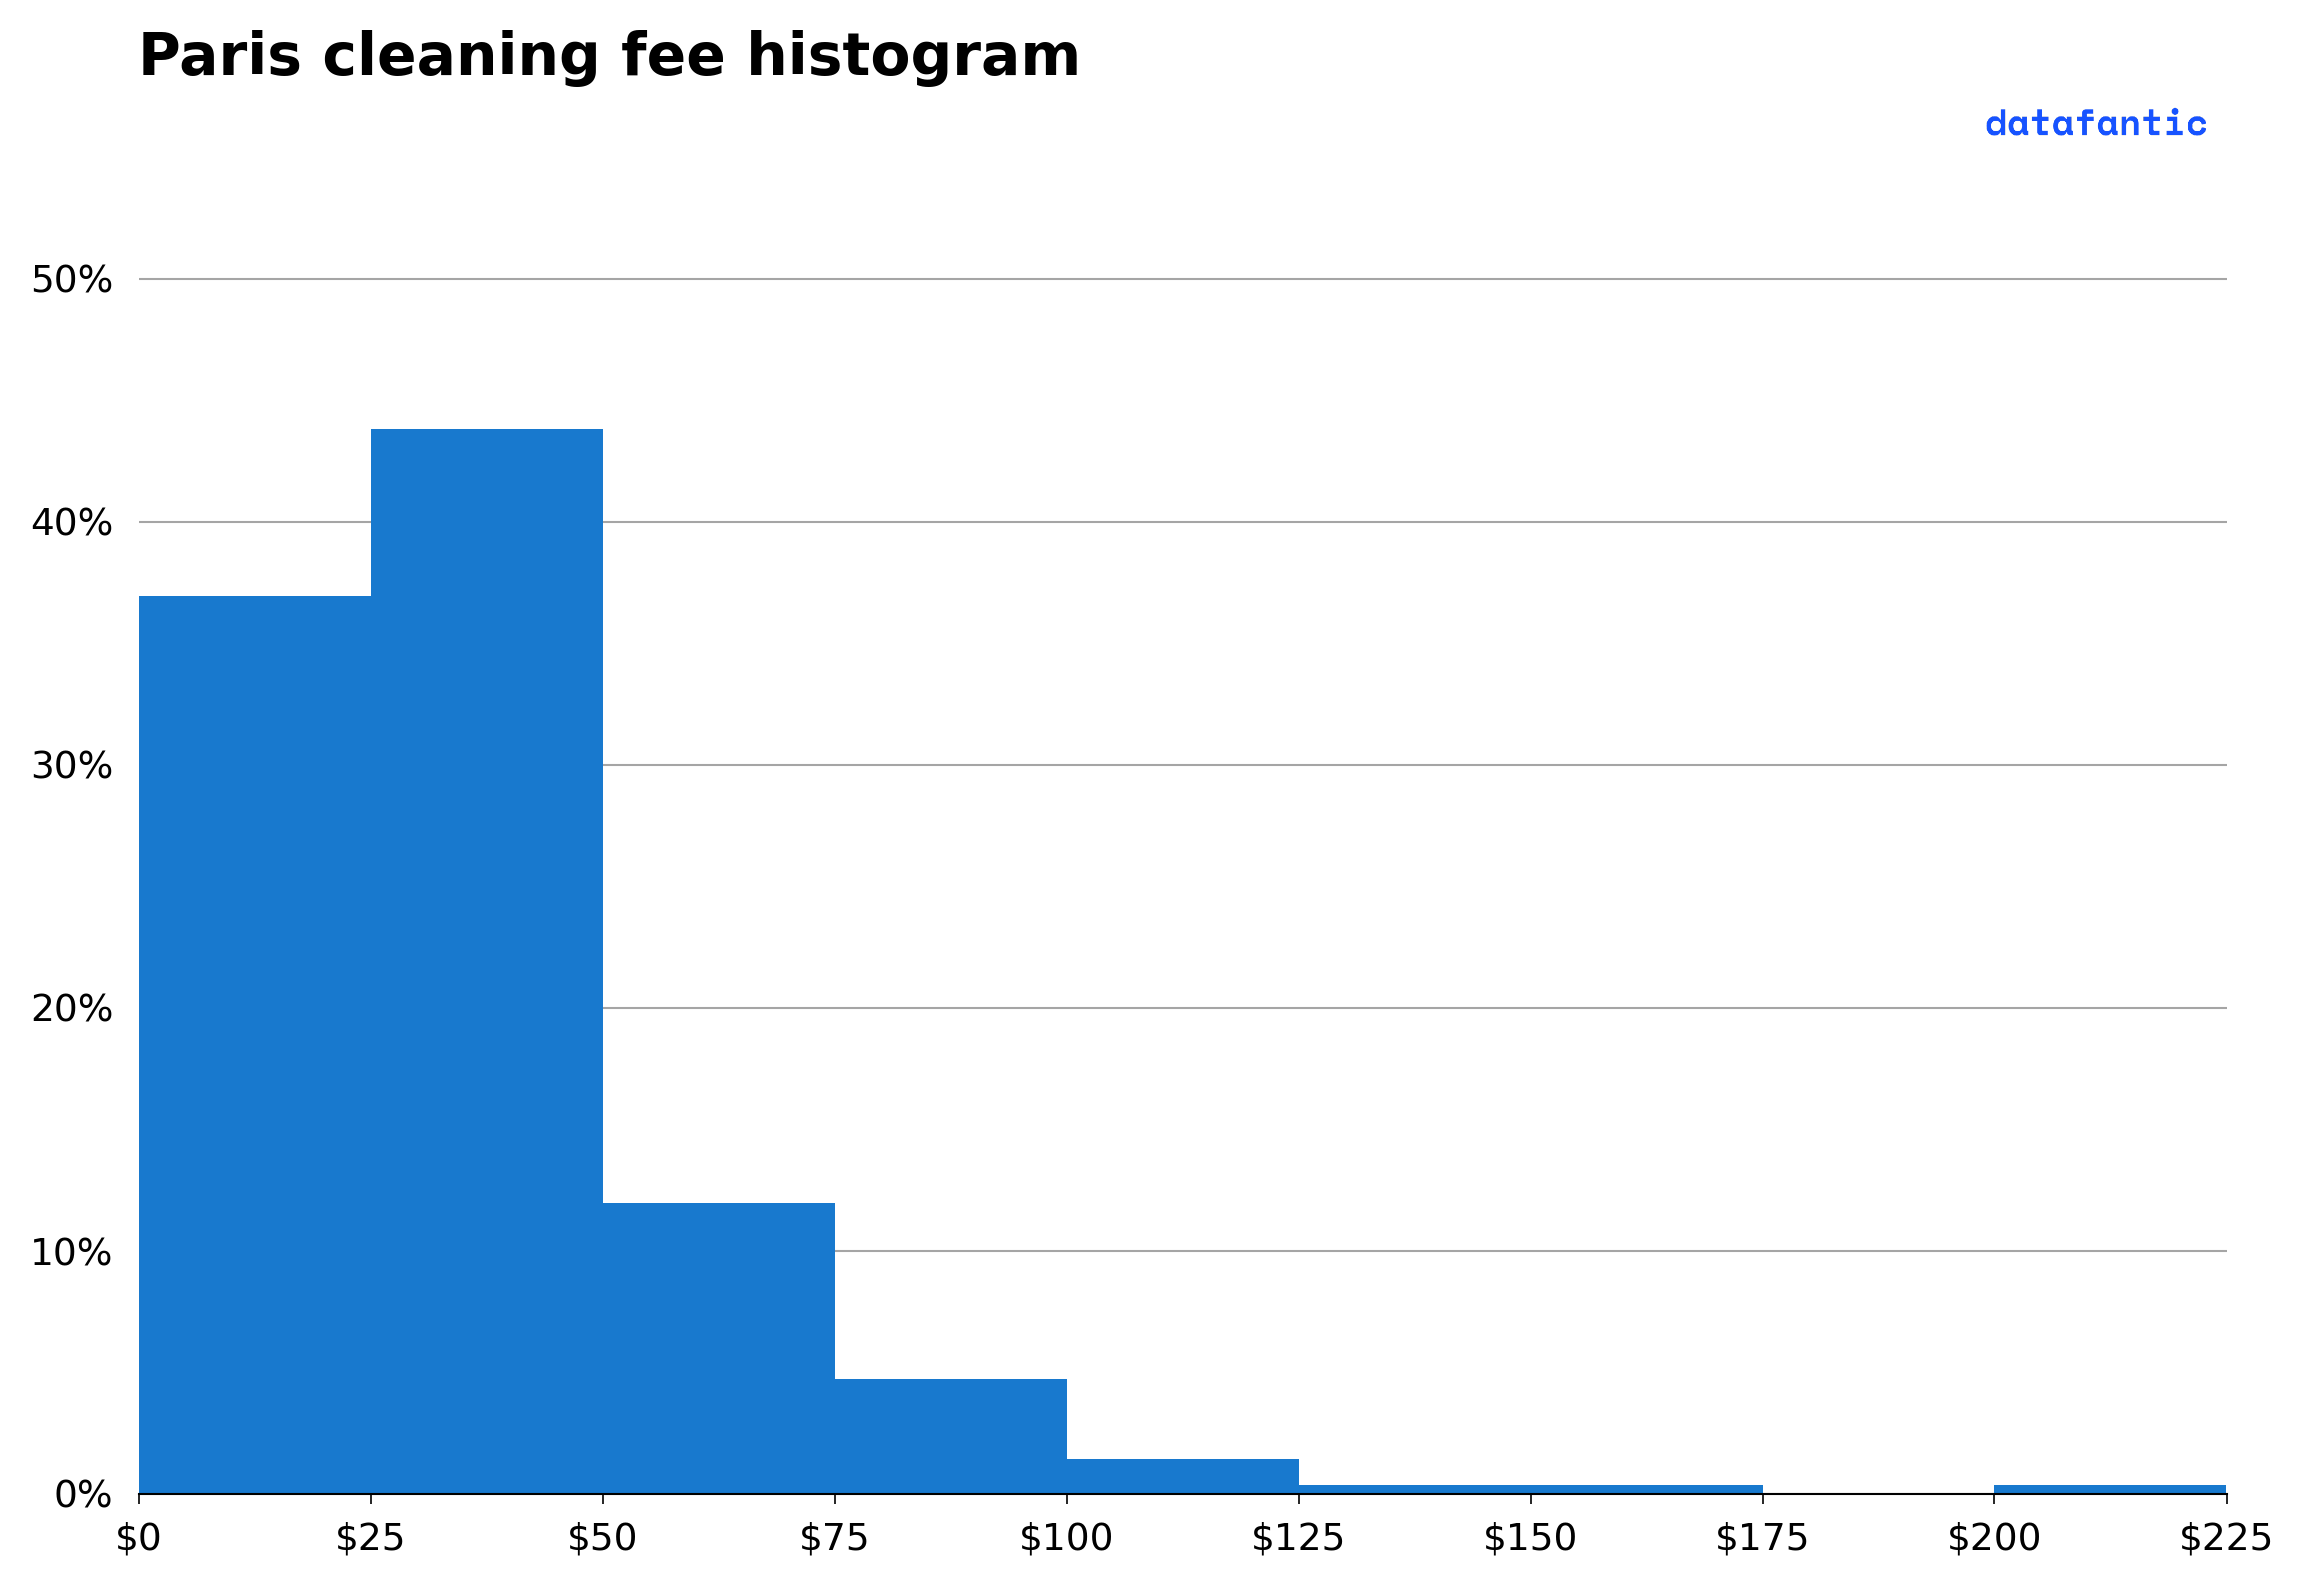

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'Paris']['cleaning_fee']
fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25), 
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .55)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Paris cleaning fee histogram""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

In [ ]:
flexible_listings[(flexible_listings['city'] == 'Austin') & (flexible_listings['cleaning_fee'] > 150)]

,weekly_discount,long_stay_discount,cleaning_fee,service_fee,price_minus_fees,title,guest,bedrooms,beds,baths,url,location,check_in,check_out,stay_days,city
299,NaN,NaN,175,85,506,Entire rental unit hosted by Shirlene,6,2.0,2.0,2,https://www.airbnb.com/rooms/50197119?adults=1...,Austin--TX--United-States,2022-10-24,2022-10-31,7,Austin
303,NaN,NaN,175,81,397,Entire rental unit hosted by Shirlene,2,NaN,1.0,1,https://www.airbnb.com/rooms/50659893?adults=1...,Austin--TX--United-States,2022-10-24,2022-10-30,6,Austin
310,NaN,NaN,175,67,300,Entire rental unit hosted by Shirlene,3,NaN,1.0,1,https://www.airbnb.com/rooms/46338510?adults=1...,Austin--TX--United-States,2022-10-23,2022-10-28,5,Austin
313,NaN,NaN,175,78,380,Entire rental unit hosted by Shirlene,4,2.0,2.0,1,https://www.airbnb.com/rooms/54041209?adults=1...,Austin--TX--United-States,2022-10-23,2022-10-29,6,Austin
314,NaN,NaN,175,63,274,Entire rental unit hosted by Shirlene,4,1.0,1.0,1,https://www.airbnb.com/rooms/32441667?adults=1...,Austin--TX--United-States,2022-10-24,2022-10-29,5,Austin
316,NaN,NaN,175,81,397,Entire rental unit hosted by Shirlene,4,1.0,2.0,1,https://www.airbnb.com/rooms/62016700224951610...,Austin--TX--United-States,2022-10-23,2022-10-29,6,Austin
317,NaN,NaN,175,105,668,Entire rental unit hosted by Shirlene,4,1.0,3.0,1,https://www.airbnb.com/rooms/62018601208919202...,Austin--TX--United-States,2022-10-30,2022-11-06,7,Austin
318,NaN,NaN,175,95,497,Entire rental unit hosted by Shirlene,4,2.0,2.0,2,https://www.airbnb.com/rooms/54041377?adults=1...,Austin--TX--United-States,2022-10-24,2022-10-30,6,Austin
319,NaN,NaN,175,93,569,Entire rental unit hosted by Shirlene,3,1.0,1.0,1,https://www.airbnb.com/rooms/46420312?adults=1...,Austin--TX--United-States,2022-10-25,2022-11-01,7,Austin
320,NaN,NaN,175,66,290,Entire rental unit hosted by Shirlene,4,1.0,3.0,1,https://www.airbnb.com/rooms/69299110895293755...,Austin--TX--United-States,2022-10-30,2022-11-04,5,Austin


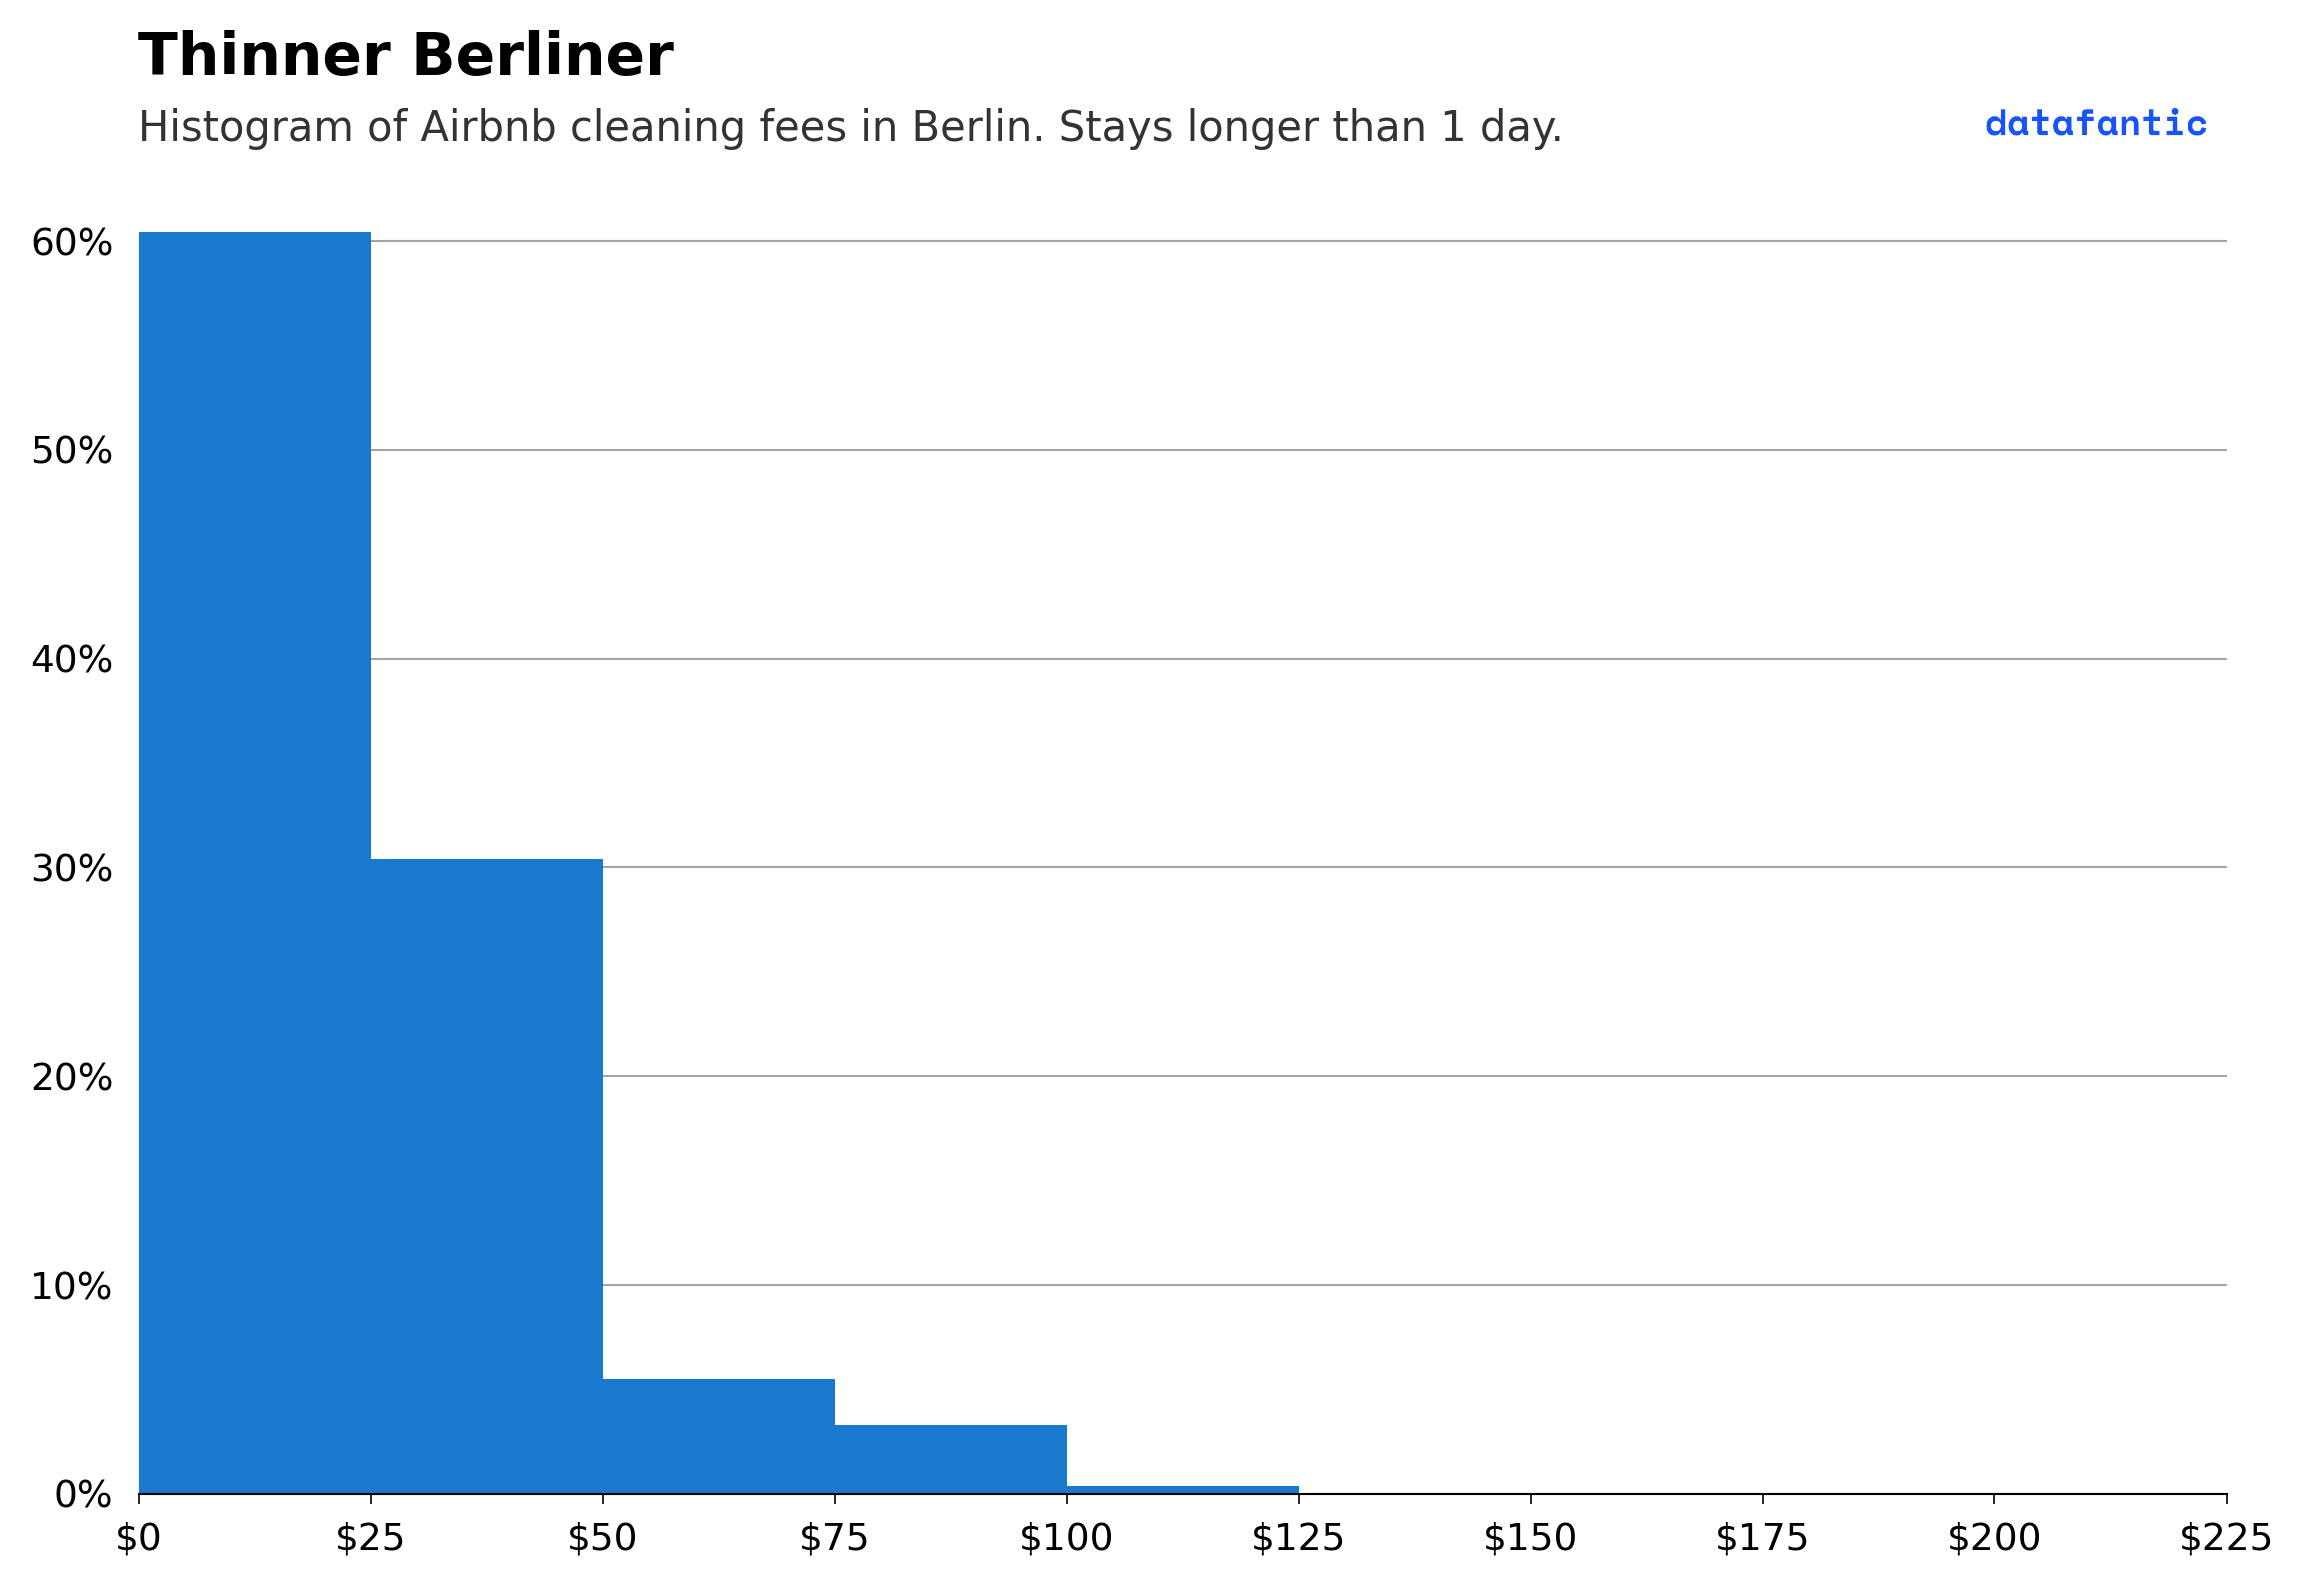

In [ ]:
data = flexible_listings[flexible_listings['city'] == 'Berlin']['cleaning_fee']

fig, ax = plt.subplots()
ax.hist(data, 
        bins=range(0, 400, 25),
        weights=np.ones(len(data)) / len(data))

ax.set_xlim(0, 225)
#ax.set_ylim(0, 1700)
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, .64)

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Thinner Berliner""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')
ax.text(x=.08, y=.89, 
        s="Histogram of Airbnb cleaning fees in Berlin. Stays longer than 1 day.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.99,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/berlin_histogram.png')

## What percentage of the cleaning fee is the total cost of the stay?

In [ ]:
flexible_listings['id'] = flexible_listings['url'].str.split("?").str.get(0).str.split("rooms/").str.get(1)
one_day_listings['id'] = one_day_listings['url'].str.split("?").str.get(0).str.split("rooms/").str.get(1)

In [ ]:
matched_listings = flexible_listings.merge(one_day_listings, how='inner', on='id')

In [ ]:
matched_listings.columns

Index(['weekly_discount_x', 'long_stay_discount_x', 'cleaning_fee_x',
       'service_fee_x', 'price_minus_fees_x', 'title_x', 'guest_x',
       'bedrooms_x', 'beds_x', 'baths_x', 'url_x', 'location_x', 'check_in_x',
       'check_out_x', 'stay_days_x', 'city_x', 'id', 'weekly_discount_y',
       'long_stay_discount_y', 'cleaning_fee_y', 'service_fee_y',
       'price_minus_fees_y', 'title_y', 'guest_y', 'bedrooms_y', 'beds_y',
       'baths_y', 'url_y', 'location_y', 'check_in_y', 'check_out_y',
       'stay_days_y', 'city_y'],
      dtype='object')

In [ ]:
matched_listings[['cleaning_fee_x','cleaning_fee_y']].mean()

cleaning_fee_x    37.980630
cleaning_fee_y    34.886199
dtype: float64

Note this price total is exclusive of discounts. 

In [ ]:
flexible_listings['price_total'] = flexible_listings[['cleaning_fee','service_fee','price_minus_fees']].sum('columns')
flexible_listings['cleaning_fee_ratio'] = (flexible_listings['cleaning_fee'] / flexible_listings['price_total'])

In [ ]:
one_day_listings['price_total'] = one_day_listings[['cleaning_fee','service_fee','price_minus_fees']].sum('columns')
one_day_listings['cleaning_fee_ratio'] = (one_day_listings['cleaning_fee'] / one_day_listings['price_total'])

In [ ]:
one_day_avg = one_day_listings[one_day_listings['cleaning_fee_ratio'] > 0]['cleaning_fee_ratio'].mean()
one_day_avg

0.2567421095914405

In [ ]:
flexible_listings[flexible_listings['cleaning_fee_ratio'] > 0].groupby(by='stay_days').mean()['cleaning_fee_ratio']

stay_days
5    0.091761
6    0.080735
7    0.070738
Name: cleaning_fee_ratio, dtype: float64

In [ ]:
cleaning_ratios = list(flexible_listings[flexible_listings['cleaning_fee_ratio'] > 0].groupby(by='stay_days').mean()['cleaning_fee_ratio'].values)

Let's calculate this separately for US cities so I can compare it in the article.

In [ ]:
us_cities = 'Austin|Dallas|Angeles|Francisco|York'

In [ ]:
flexible_listings[flexible_listings['city'].str.contains(us_cities)]['city'].unique()

array(['Dallas', 'Austin', 'Los Angeles', 'New York City',
       'San Francisco'], dtype=object)

In [ ]:
flexible_listings[(flexible_listings['cleaning_fee_ratio'] > 0) & (flexible_listings['city'].str.contains(us_cities))].groupby(by='stay_days').mean()['cleaning_fee_ratio']

stay_days
5    0.104057
6    0.103691
7    0.088404
Name: cleaning_fee_ratio, dtype: float64

In [ ]:
one_day_listings[(one_day_listings['cleaning_fee_ratio'] > 0) & (one_day_listings['city'].str.contains(us_cities))]['cleaning_fee_ratio'].mean()

0.27876845657082067

What about non-us cities?

In [ ]:
flexible_listings[(flexible_listings['cleaning_fee_ratio'] > 0) & (~flexible_listings['city'].str.contains(us_cities))].groupby(by='stay_days').mean()['cleaning_fee_ratio']

stay_days
5    0.081278
6    0.063245
7    0.056643
Name: cleaning_fee_ratio, dtype: float64

In [ ]:
one_day_listings[(one_day_listings['cleaning_fee_ratio'] > 0) & (~one_day_listings['city'].str.contains(us_cities))]['cleaning_fee_ratio'].mean()

0.23558809318550125

Separate question, what percentage of listings outside the US have no cleaning fee.

In [ ]:
one_day_listings[(one_day_listings['cleaning_fee_ratio'] == 0) & (~one_day_listings['city'].str.contains(us_cities))].shape[0]

763

In [ ]:
one_day_listings[(one_day_listings['cleaning_fee_ratio'] > 0) & (~one_day_listings['city'].str.contains(us_cities))].shape[0]

1313

In [ ]:
(one_day_listings[(one_day_listings['cleaning_fee_ratio'] == 0) & (~one_day_listings['city'].str.contains(us_cities))].shape[0] / 
 one_day_listings[(one_day_listings['cleaning_fee_ratio'] > 0) & (~one_day_listings['city'].str.contains(us_cities))].shape[0])

0.5811119573495811

In [ ]:
(flexible_listings[(flexible_listings['cleaning_fee_ratio'] == 0) & (~flexible_listings['city'].str.contains(us_cities))].shape[0] / 
 flexible_listings[(flexible_listings['cleaning_fee_ratio'] > 0) & (~flexible_listings['city'].str.contains(us_cities))].shape[0])

0.20509633312616532

And the opposite, inside the US

In [ ]:
(one_day_listings[(one_day_listings['cleaning_fee_ratio'] == 0) & (one_day_listings['city'].str.contains(us_cities))].shape[0] / 
 one_day_listings[(one_day_listings['cleaning_fee_ratio'] > 0) & (one_day_listings['city'].str.contains(us_cities))].shape[0])

0.18160190325138778

In [ ]:
(flexible_listings[(flexible_listings['cleaning_fee_ratio'] == 0) & (flexible_listings['city'].str.contains(us_cities))].shape[0] / 
 flexible_listings[(flexible_listings['cleaning_fee_ratio'] > 0) & (flexible_listings['city'].str.contains(us_cities))].shape[0])

0.09337349397590361

Ok let's move back to the full data and make the chart.

In [ ]:
cleaning_ratios.insert(0, one_day_avg)

In [ ]:
cleaning_ratios = [round(x * 100, 1) for x in cleaning_ratios]
cleaning_ratios

[25.7, 9.2, 8.1, 7.1]

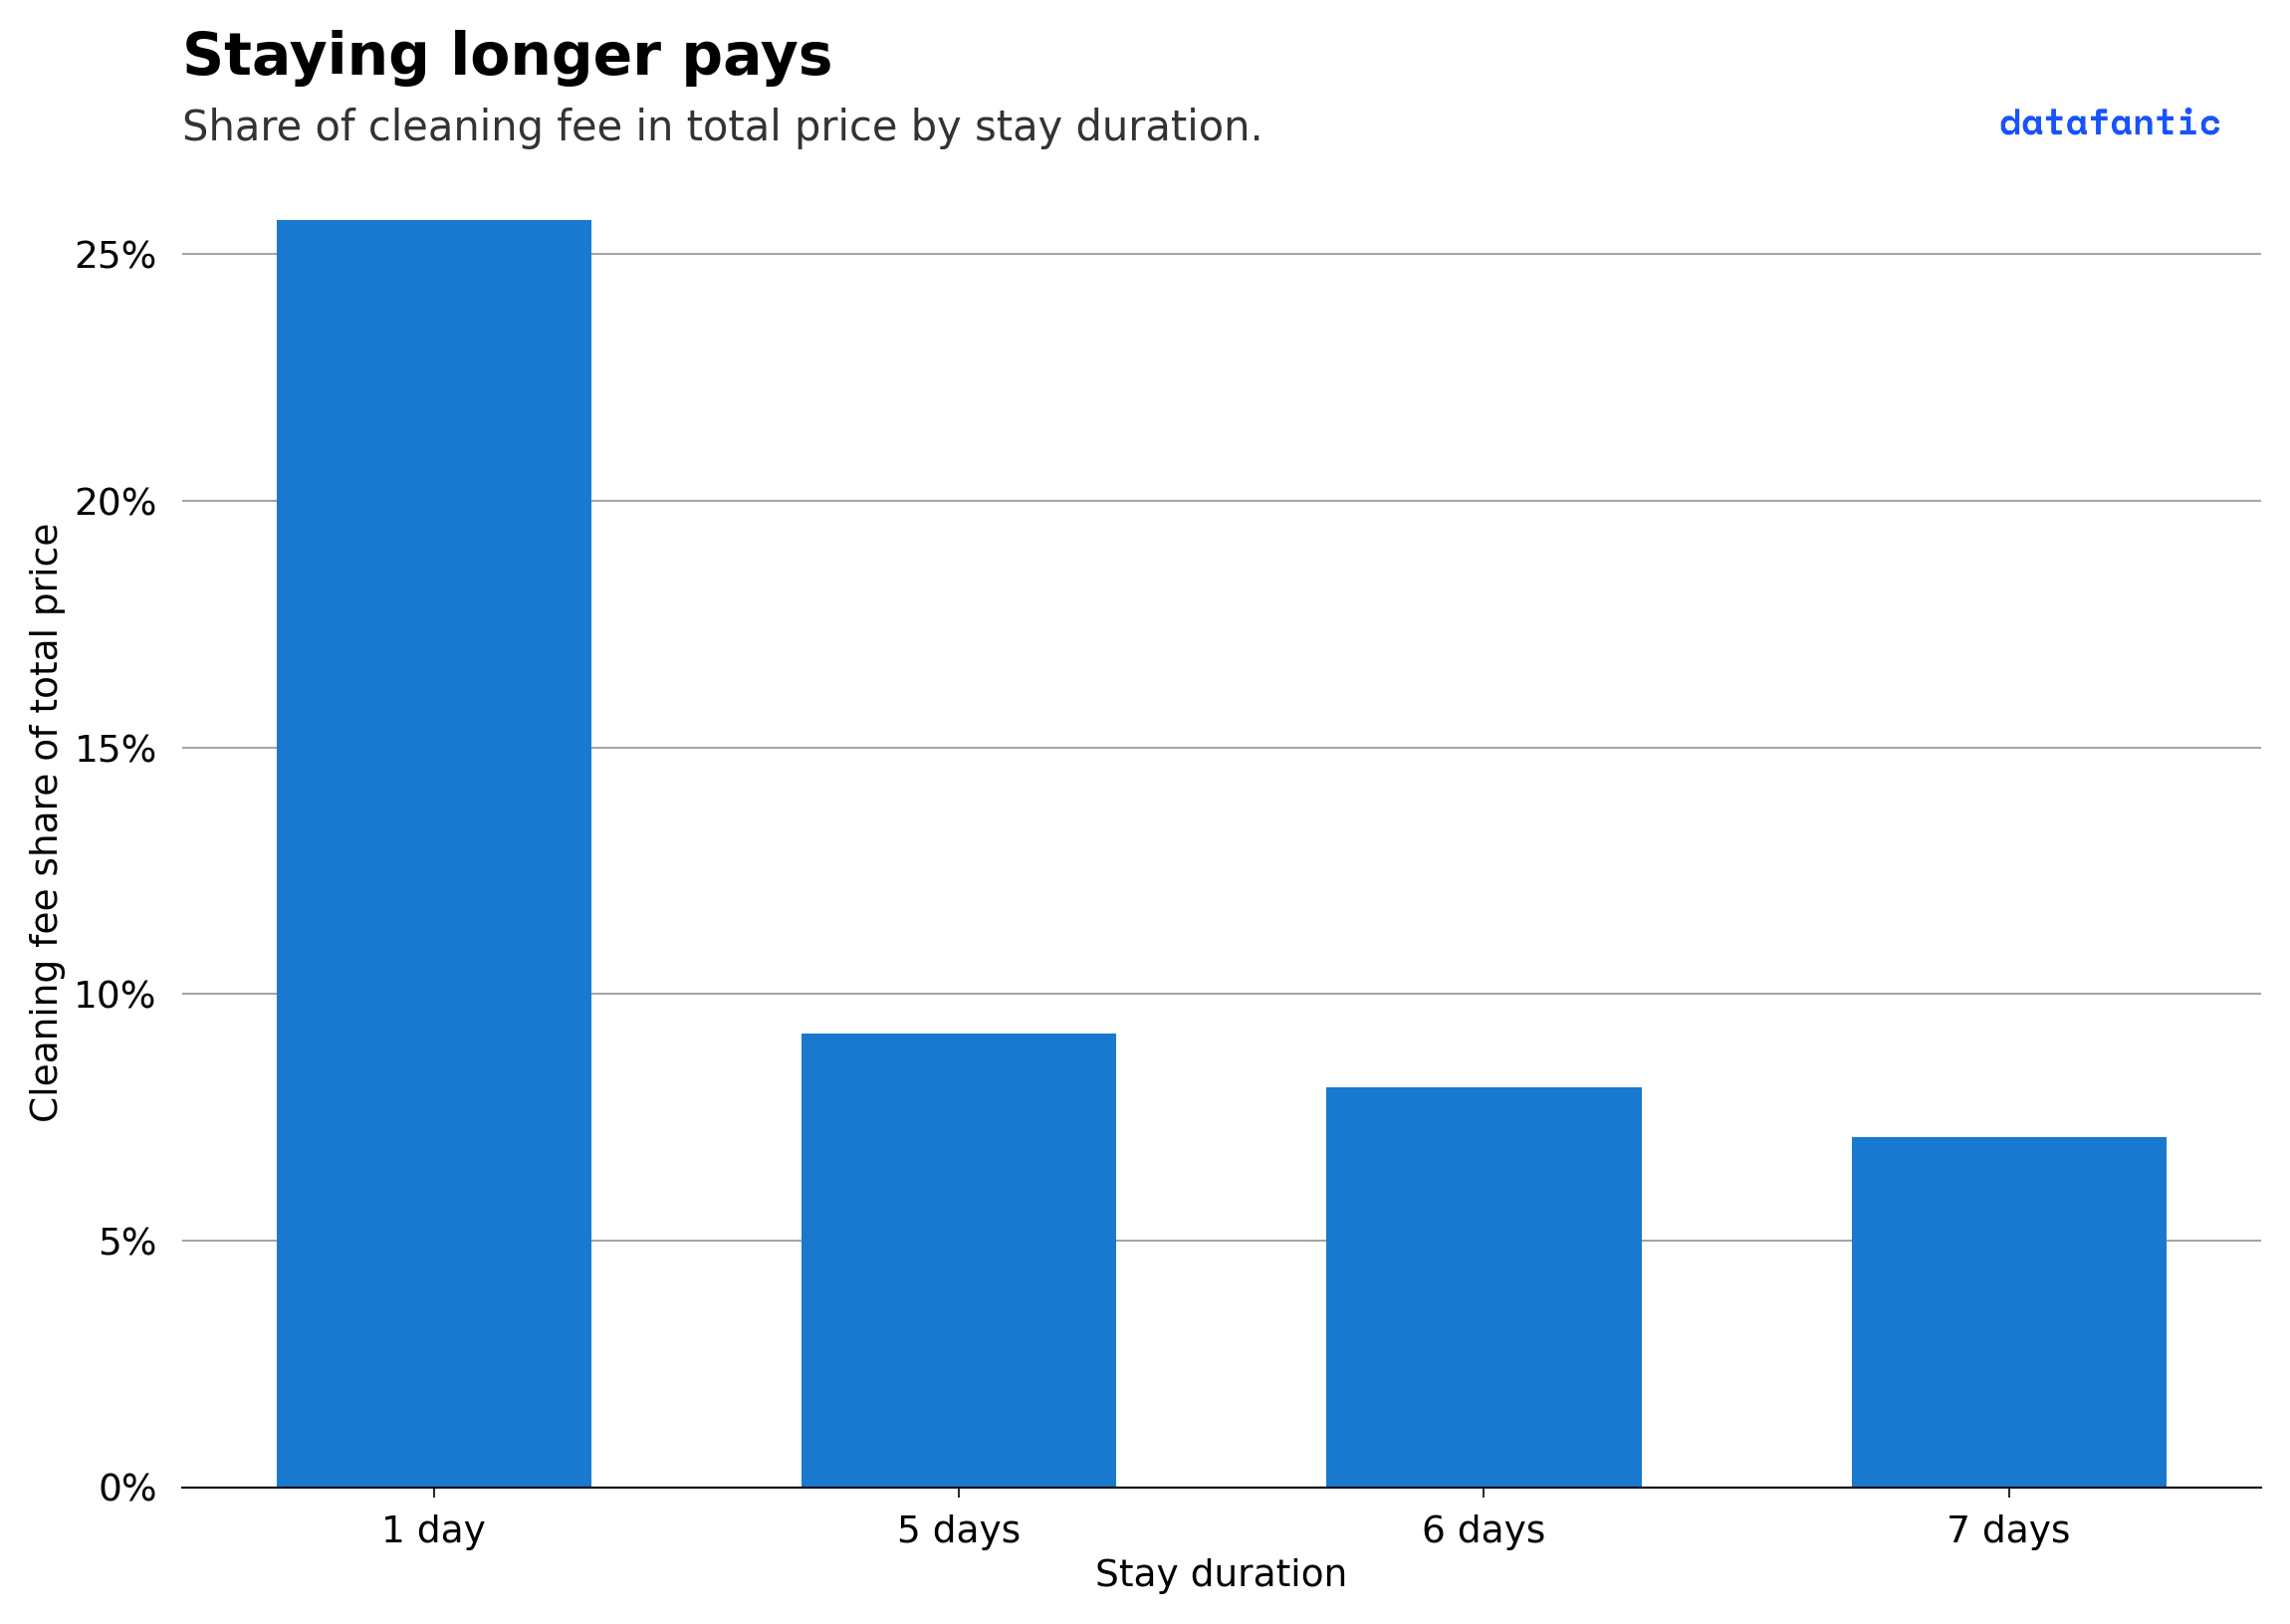

In [ ]:
fig, ax = plt.subplots()
ax.bar(['1 day', '5 days', '6 days', '7 days'], cleaning_ratios, width=.6)

ax.yaxis.set_major_formatter('{x:1.0f}%')
ax.set_ylabel("Cleaning fee share of total price")
ax.set_xlabel("Stay duration")

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Staying longer pays""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')
ax.text(x=.08, y=.89, 
        s="Share of cleaning fee in total price by stay duration.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.98,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/stay_duration.png')

## Is there any commonality for listings with higher cleaning fees? 

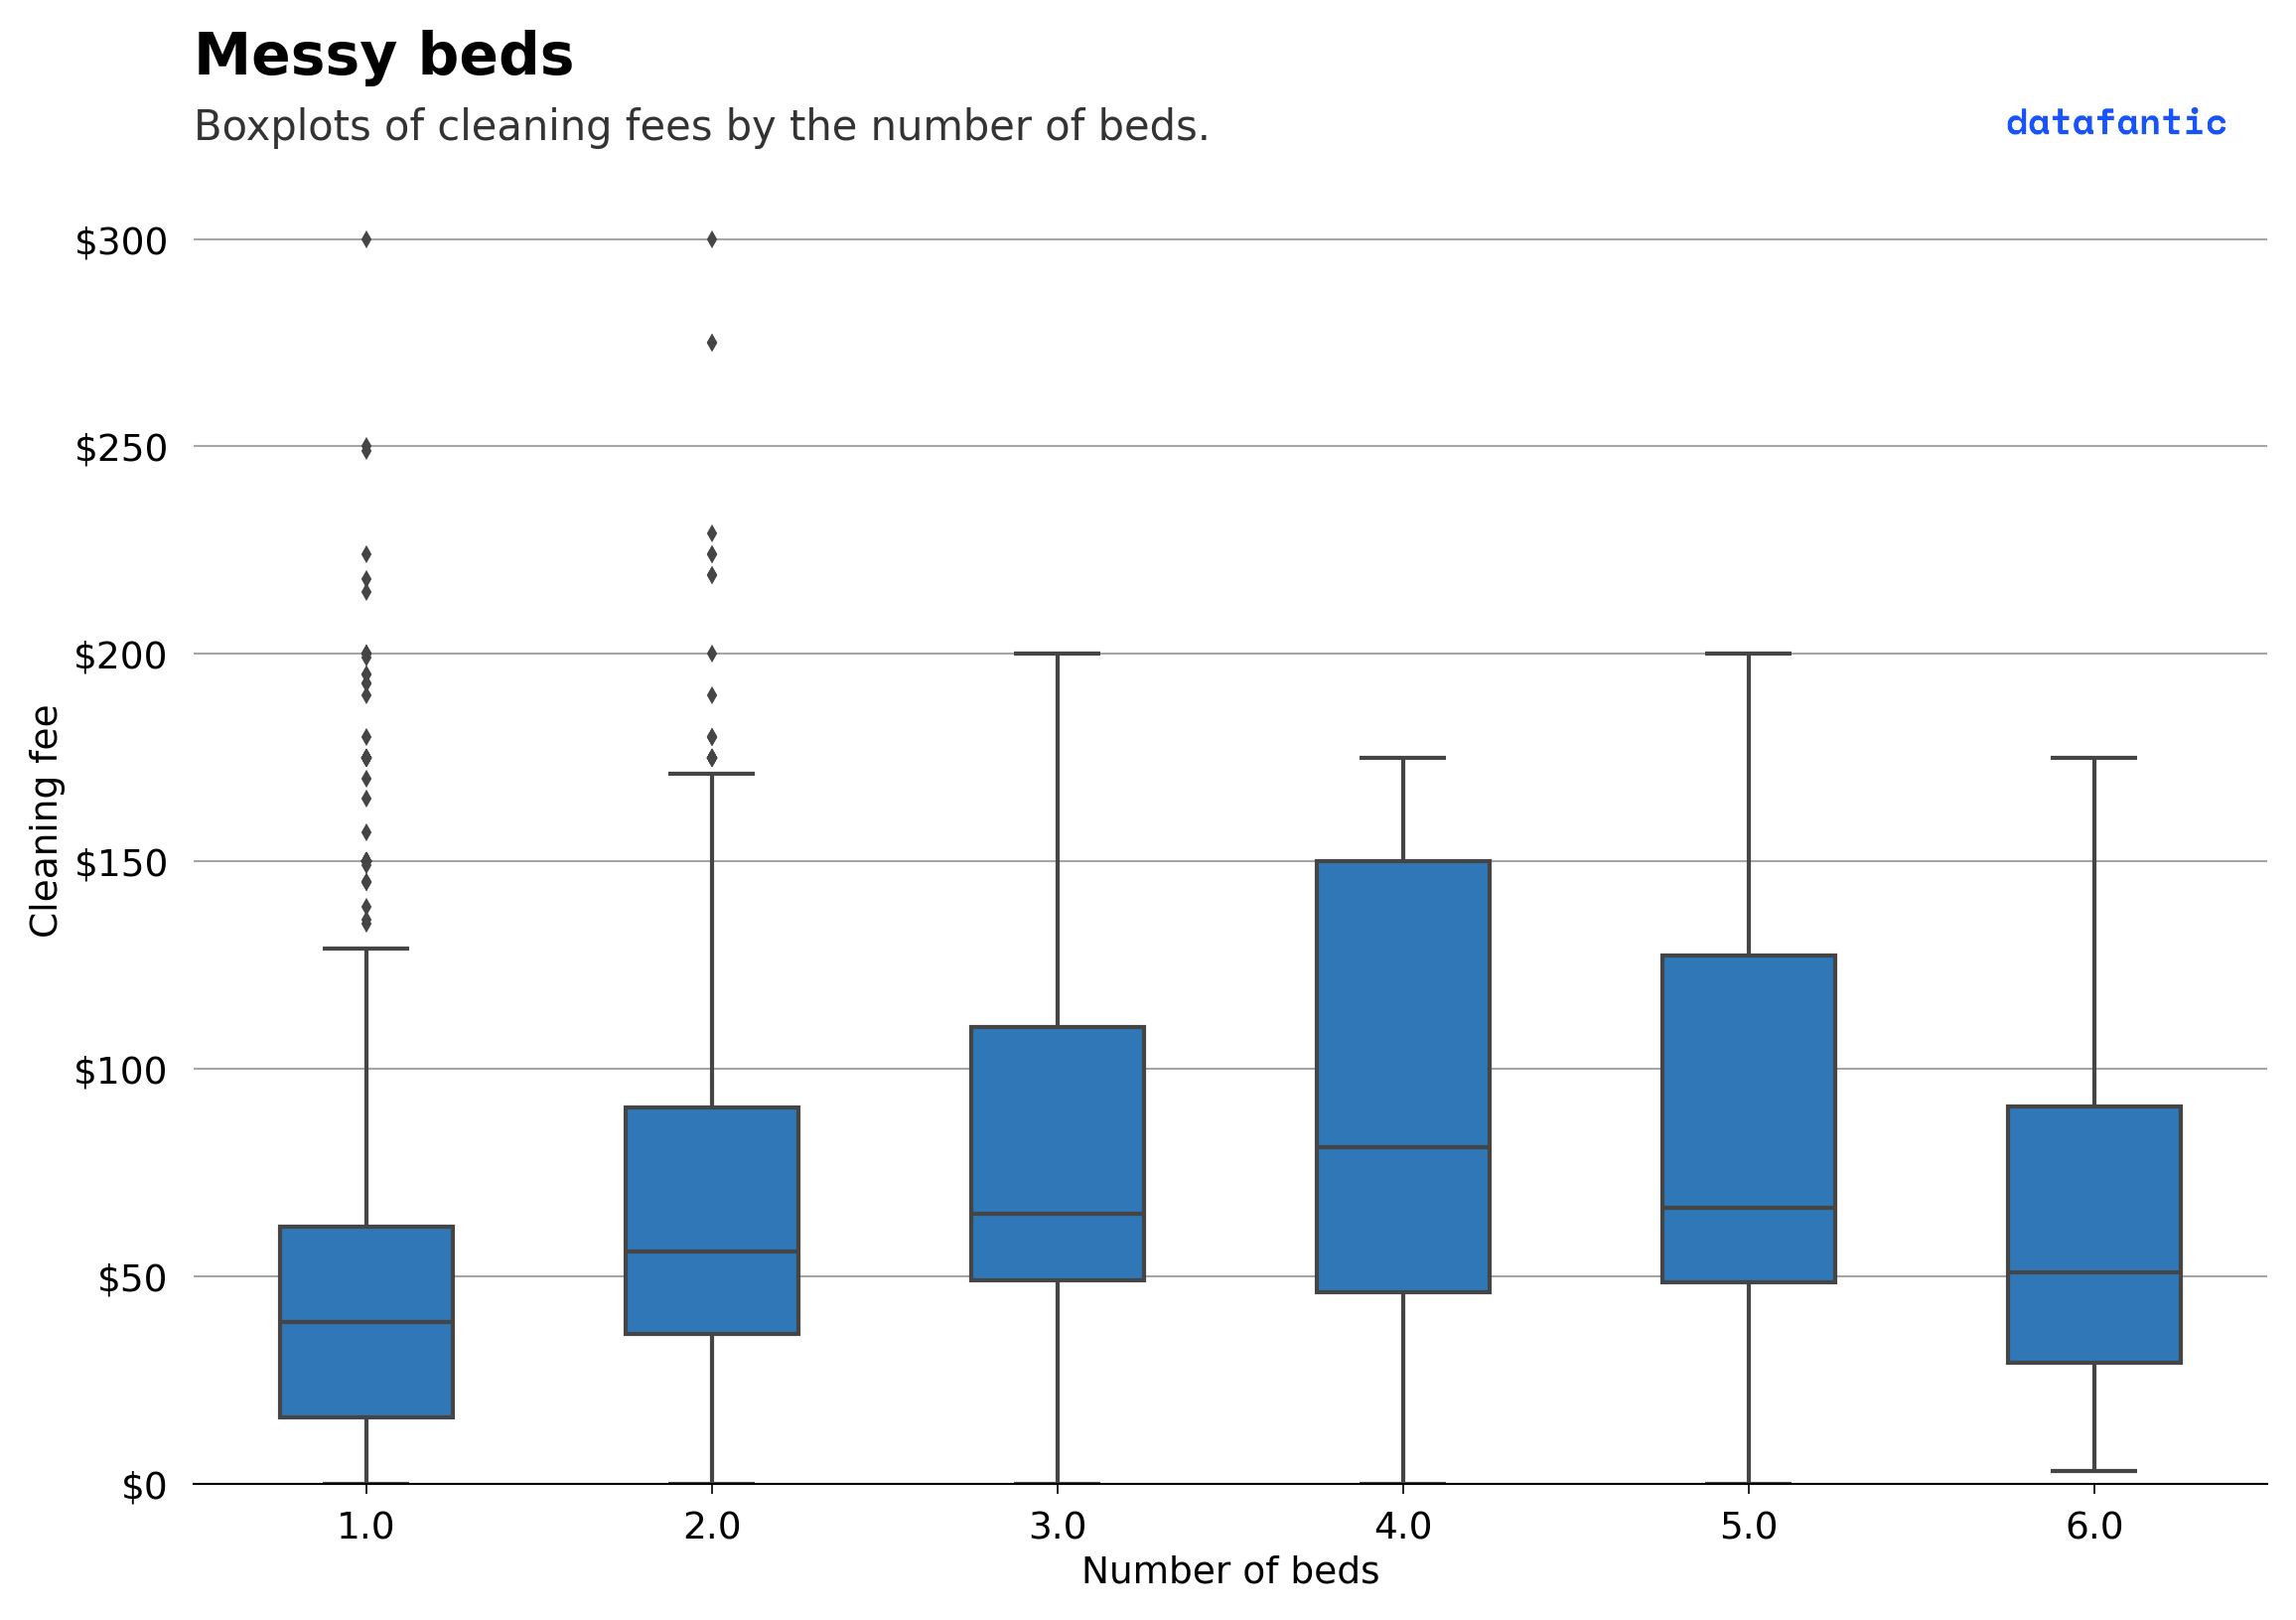

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data=flexible_listings[flexible_listings['beds'] < 7], 
            x='beds', y='cleaning_fee', 
            ax=ax, 
            color='#1879CE', 
            width=.5, linewidth=2)
ax.set_ylim(0, 320)

ax.set_ylabel("Cleaning fee")
ax.set_xlabel("Number of beds")

ax.yaxis.set_major_formatter('${x:1.0f}')

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Messy beds""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')
ax.text(x=.08, y=.89, 
        s="Boxplots of cleaning fees by the number of beds.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.98,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/fees_beds.png')

In [ ]:
flexible_listings[(flexible_listings['beds'] < 7) & (flexible_listings['city'] == 'Austin')]

,weekly_discount,long_stay_discount,cleaning_fee,service_fee,price_minus_fees,title,guest,bedrooms,beds,baths,url,location,check_in,check_out,stay_days,city,id,price_total,cleaning_fee_ratio
295,NaN,NaN,50,54,330,Tiny home hosted by Trish,2,1.0,1.0,1,https://www.airbnb.com/rooms/4906733?adults=1&...,Austin--TX--United-States,2022-12-18,2022-12-23,5,Austin,4906733,434,0.115207
296,NaN,NaN,70,88,550,Entire rental unit hosted by Leon And Stella,2,1.0,1.0,1,https://www.airbnb.com/rooms/13658208?adults=1...,Austin--TX--United-States,2022-10-25,2022-10-30,5,Austin,13658208,708,0.098870
297,NaN,NaN,19,49,329,Private room in guest suite hosted by Nate,1,1.0,1.0,1,https://www.airbnb.com/rooms/20036438?adults=1...,Austin--TX--United-States,2022-10-25,2022-10-31,6,Austin,20036438,397,0.047859
298,NaN,NaN,50,104,687,Entire rental unit hosted by Ana Maria,2,1.0,1.0,1,https://www.airbnb.com/rooms/48071617?adults=1...,Austin--TX--United-States,2022-11-01,2022-11-08,7,Austin,48071617,841,0.059453
299,NaN,NaN,175,85,506,Entire rental unit hosted by Shirlene,6,2.0,2.0,2,https://www.airbnb.com/rooms/50197119?adults=1...,Austin--TX--United-States,2022-10-24,2022-10-31,7,Austin,50197119,766,0.228460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,NaN,NaN,60,114,750,Entire rental unit hosted by Diamantina,3,1.0,1.0,1,https://www.airbnb.com/rooms/8390607?adults=1&...,Austin--TX--United-States,2022-10-25,2022-10-30,5,Austin,8390607,924,0.064935
583,NaN,NaN,95,114,710,Entire bungalow hosted by Roman,4,1.0,2.0,1,https://www.airbnb.com/rooms/plus/890163?adult...,Austin--TX--United-States,2022-10-30,2022-11-04,5,Austin,plus/890163,919,0.103373
584,NaN,NaN,85,90,550,Entire home hosted by Rainboat,4,1.0,2.0,1,https://www.airbnb.com/rooms/41983088?adults=1...,Austin--TX--United-States,2022-11-06,2022-11-11,5,Austin,41983088,725,0.117241
585,NaN,NaN,65,118,770,Entire guesthouse hosted by Nina,2,1.0,1.0,1,https://www.airbnb.com/rooms/50851667?adults=1...,Austin--TX--United-States,2022-11-04,2022-11-10,6,Austin,50851667,953,0.068206


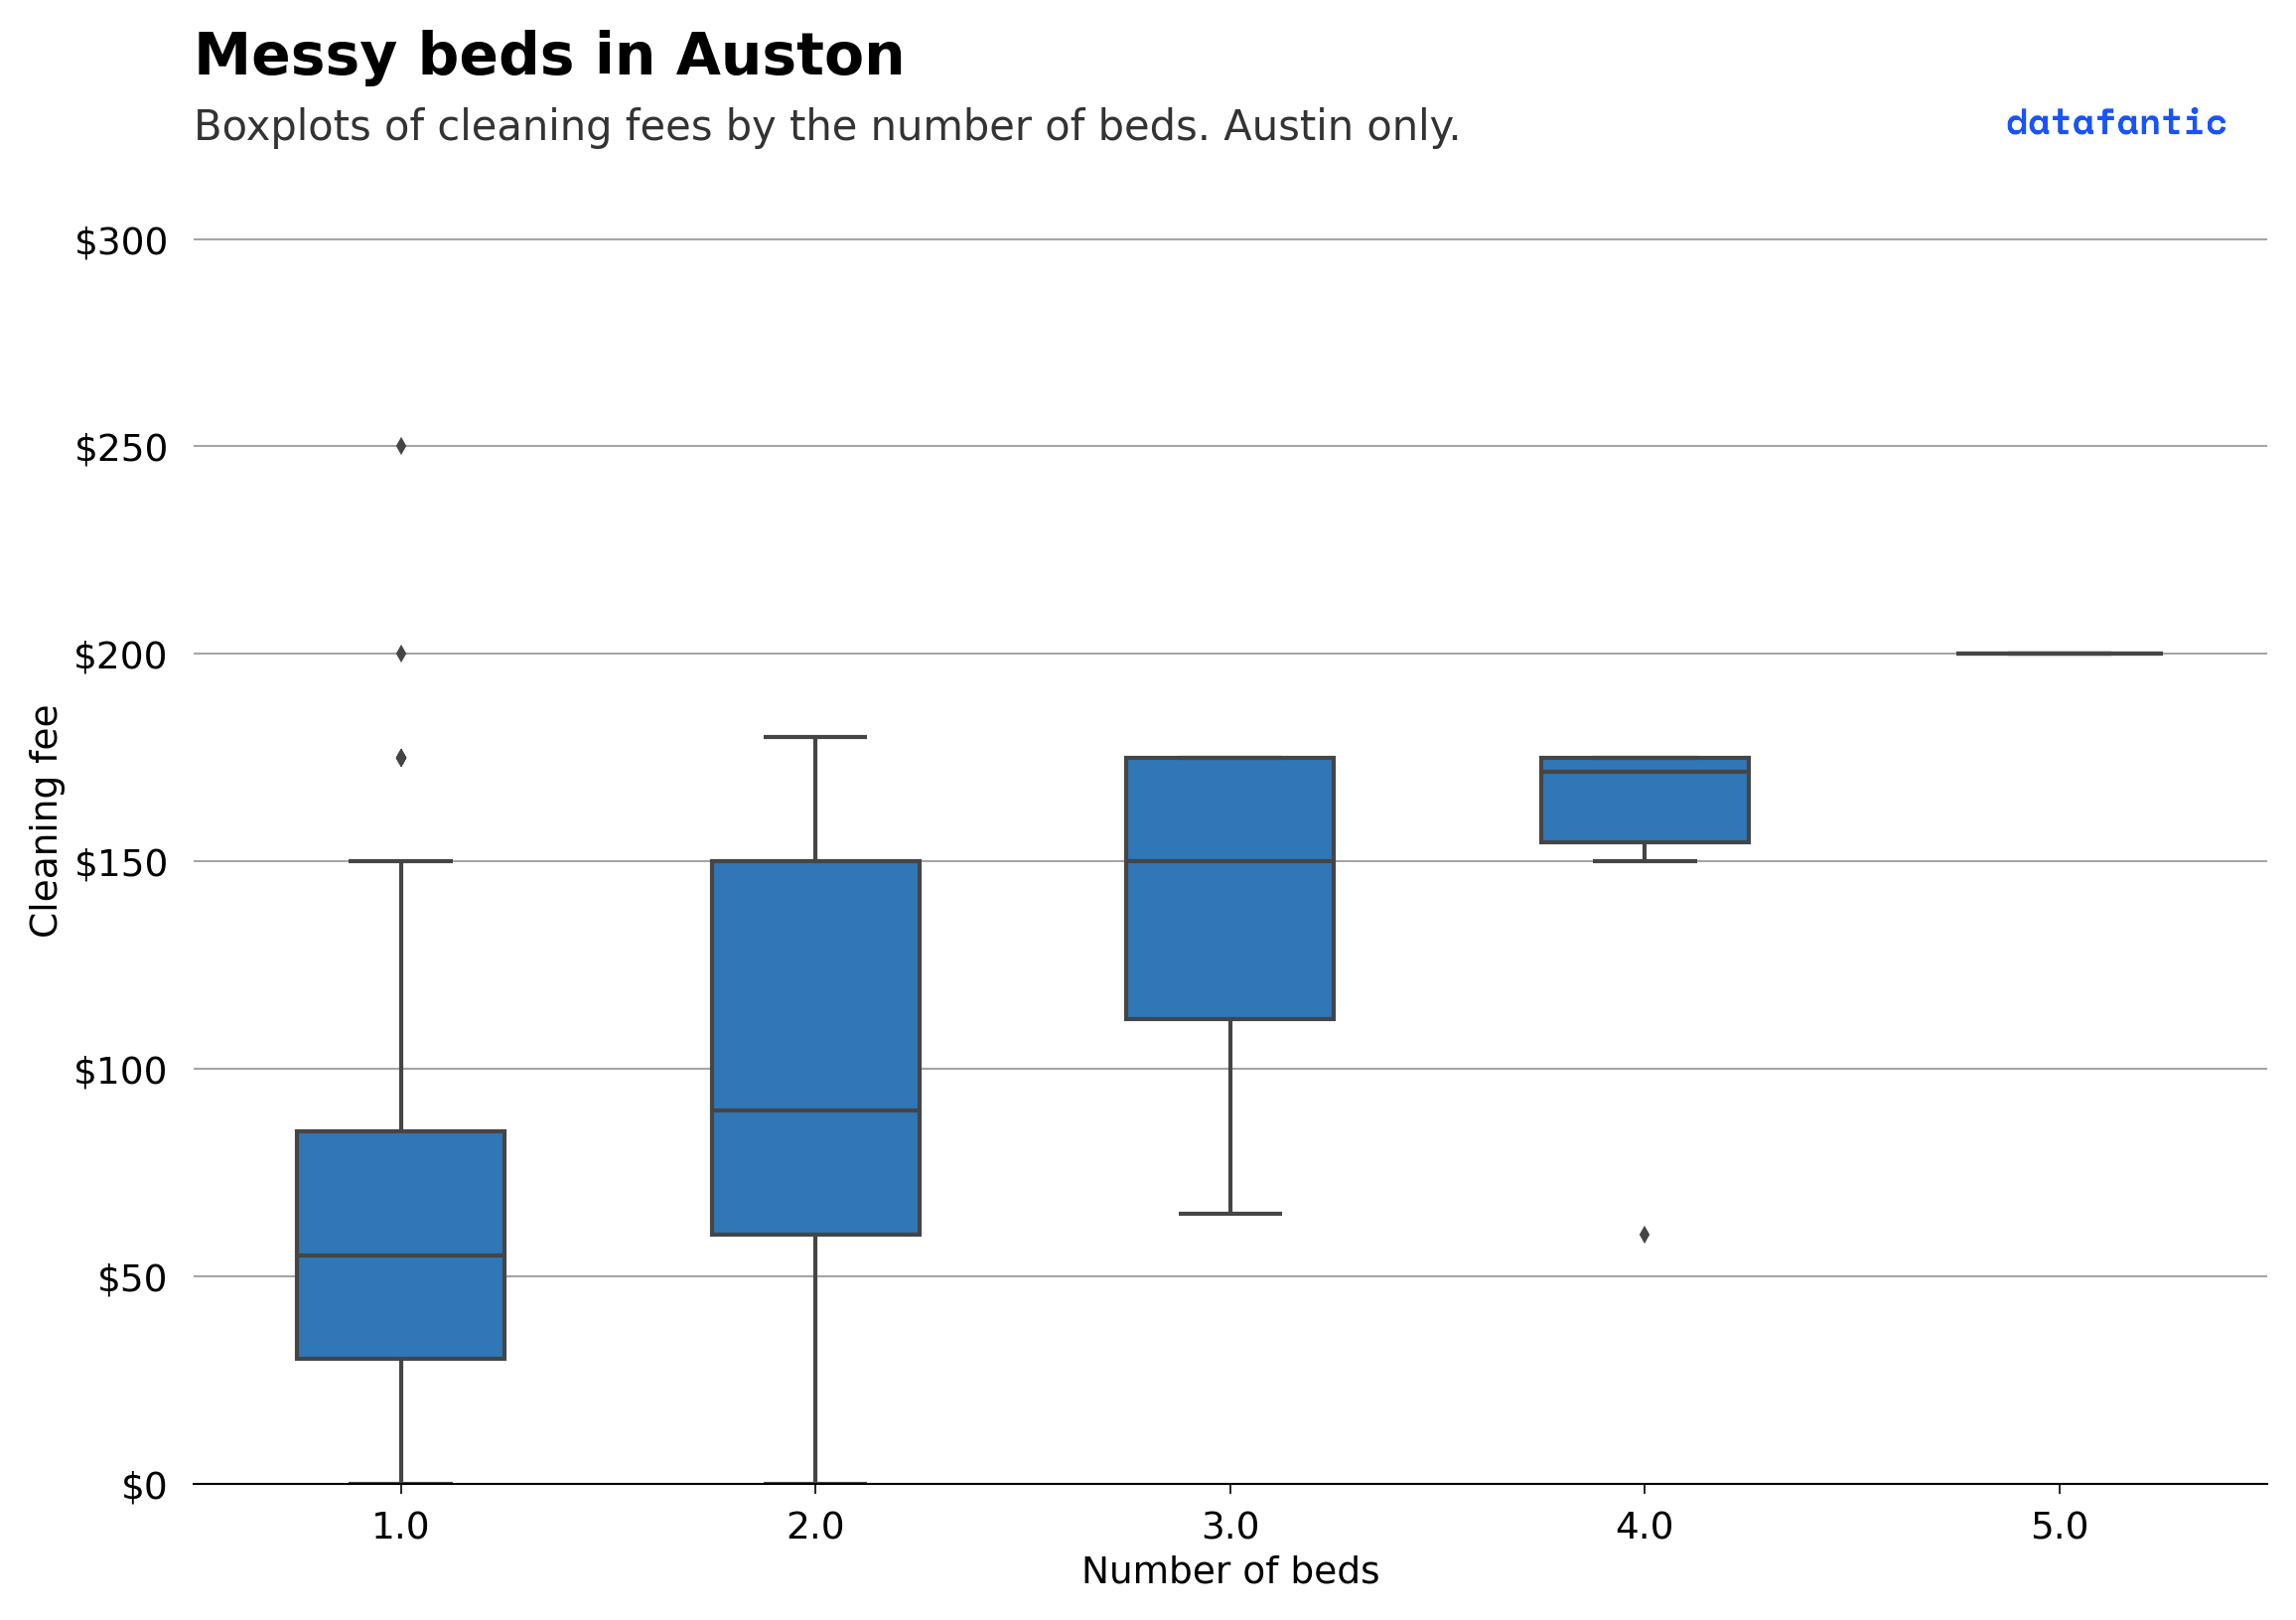

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data=flexible_listings[(flexible_listings['beds'] < 7) & (flexible_listings['city'] == 'Austin')], 
            x='beds', y='cleaning_fee', 
            ax=ax, 
            color='#1879CE', 
            width=.5, linewidth=2)
ax.set_ylim(0, 320)

ax.set_ylabel("Cleaning fee")
ax.set_xlabel("Number of beds")

ax.yaxis.set_major_formatter('${x:1.0f}')

# Add in title and subtitle
ax.text(x=.08, y=.93, 
        s="""Messy beds in Austin""",
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        weight='bold')
ax.text(x=.08, y=.89, 
        s="Boxplots of cleaning fees by the number of beds. Austin only.", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.25)
ab = AnnotationBbox(imagebox, xy=(.98,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a09bbfb-7f5f-46b3-8fa0-788f71b2887f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>